In [1]:
# import os
# import json
# import pandas as pd
# import glob
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from pathlib import Path
# import re

# # --- Configuration ---
# # Adjust these paths to match your folder names
# PREDICTIONS_DIR = "../EvaluateErrorDetectionResults/claude_3-5_haiku_metareviews" # Treat this as the "ground truth"
# GROUND_TRUTH_DIR = "../EvaluateErrorDetectionResults/data_sampled/metareviews"      # Treat this as the "predictions"

# # --- Helper Functions ---

# def flatten_data(file_path):
#     """
#     Loads a JSON file and flattens its structure into a list of records,
#     one for each flaw evaluation.
#     """
#     records = []
#     try:
#         with open(file_path, 'r', encoding='utf-8') as f:
#             data = json.load(f)
        
#         for paper_id, flaws in data.items():
#             for flaw_eval in flaws:
#                 # Ensure the record has the necessary keys, handling potential errors
#                 if isinstance(flaw_eval, dict) and 'flaw_id' in flaw_eval:
#                     records.append({
#                         'paper_id': paper_id,
#                         'flaw_id': flaw_eval.get('flaw_id'),
#                         'is_flaw_mentioned': flaw_eval.get('is_flaw_mentioned'),
#                         'is_reasoning_correct': flaw_eval.get('is_reasoning_correct')
#                     })
#     except (json.JSONDecodeError, FileNotFoundError, IOError) as e:
#         print(f"Warning: Could not process file {file_path}. Error: {e}")
#     return records

# def calculate_metrics(df, y_true_col, y_pred_col):
#     """Calculates classification metrics between two boolean columns."""
#     # Drop rows where either label is missing to ensure a fair comparison
#     df_clean = df.dropna(subset=[y_true_col, y_pred_col])
    
#     y_true = df_clean[y_true_col]
#     y_pred = df_clean[y_pred_col]
    
#     if len(y_true) == 0:
#         return {
#             'accuracy': np.nan, 'precision': np.nan,
#             'recall': np.nan, 'f1': np.nan, 'support': 0
#         }

#     # Use zero_division=0 to handle cases where a class is not predicted
#     return {
#         'accuracy': accuracy_score(y_true, y_pred),
#         'precision': precision_score(y_true, y_pred, zero_division=0),
#         'recall': recall_score(y_true, y_pred, zero_division=0),
#         'f1': f1_score(y_true, y_pred, zero_division=0),
#         'support': len(y_true)
#     }

# # --- Main Analysis Logic ---

# def analyze_metareviewer_agreement(truth_dir, predictions_dir):
#     """
#     Finds corresponding files, aligns data, calculates agreement metrics,
#     and returns a DataFrame with the results.
#     """
#     all_results = []
    
#     # --- Step 1: Catalog all files from both directories ---
#     files_in_truth_dir = glob.glob(os.path.join(truth_dir, "**/*.json"), recursive=True)
#     files_in_predictions_dir = glob.glob(os.path.join(predictions_dir, "**/*.json"), recursive=True)

#     if not files_in_truth_dir:
#         print(f"Error: No JSON files found in the ground truth directory: {truth_dir}")
#         return pd.DataFrame()
#     if not files_in_predictions_dir:
#         print(f"Error: No JSON files found in the predictions directory: {predictions_dir}")
#         return pd.DataFrame()

#     print(f"Found {len(files_in_truth_dir)} files in {truth_dir}.")
#     print(f"Found {len(files_in_predictions_dir)} files in {predictions_dir}. Starting comparison...")

#     # --- Step 2: Parse and map files from the predictions directory ---
#     predictions_map = {}
#     for path in files_in_predictions_dir:
#         filename = os.path.basename(path)
#         try:
#             parts = filename.replace('_evaluated.json', '').split('_')
#             review_model = parts[0]
#             status = parts[-1]
#             venue = "_".join(parts[1:-1])
#             predictions_map[(review_model, venue, status)] = path
#         except IndexError:
#             print(f"Warning (predictions): Could not parse filename, skipping: {filename}")

#     # --- Step 3: Parse truth files and find matches in the predictions map ---
#     print(f"\nFound {len(predictions_map)} parsable prediction files.")
    
#     for truth_file_path in files_in_truth_dir:
#         try:
#             path_parts = Path(truth_file_path).parts
#             filename = os.path.basename(truth_file_path)
            
#             relative_path = os.path.relpath(truth_file_path, truth_dir)
#             ground_truth_metareviewer = Path(relative_path).parts[0]

#             review_model, venue, status = None, None, None
            
#             if "_evaluated.json" in filename:
#                 parts = filename.replace('_evaluated.json', '').split('_')
#                 review_model = parts[0]
#                 status = parts[-1]
#                 venue = "_".join(parts[1:-1])
#             elif "metareviews_by_" in filename:
#                 review_model = filename.replace('metareviews_by_', '').replace('.json', '')
#                 status = path_parts[-2]
#                 venue = path_parts[-3]
#             else:
#                 continue

#             prediction_key = (review_model, venue, status)
#             if prediction_key in predictions_map:
#                 prediction_file_path = predictions_map[prediction_key]
                
#                 print(f"\nMatching pair found for Review Model '{review_model}' | Venue '{venue}' | Status '{status}':")
#                 print(f"  - Truth File (from {ground_truth_metareviewer}): {os.path.relpath(truth_file_path, truth_dir)}")
#                 print(f"  - Prediction File: {os.path.basename(prediction_file_path)}")

#                 df_truth = pd.DataFrame(flatten_data(truth_file_path))
#                 df_pred = pd.DataFrame(flatten_data(prediction_file_path))

#                 if df_truth.empty or df_pred.empty:
#                     print("  - One or both files are empty or failed to load. Skipping.")
#                     continue

#                 merged_df = pd.merge(df_truth, df_pred, on=['paper_id', 'flaw_id'], suffixes=('_truth', '_pred'))

#                 if merged_df.empty:
#                     print("  - No common paper/flaw IDs found between the two files. Skipping.")
#                     continue

#                 mention_metrics = calculate_metrics(merged_df, 'is_flaw_mentioned_truth', 'is_flaw_mentioned_pred')
#                 reasoning_metrics = calculate_metrics(merged_df, 'is_reasoning_correct_truth', 'is_reasoning_correct_pred')

#                 all_results.append({
#                     'review_model': review_model,
#                     'ground_truth_metareviewer': ground_truth_metareviewer,
#                     'venue': venue,
#                     'status': status,
#                     'support': mention_metrics['support'],
#                     'f1_mention': mention_metrics['f1'],
#                     'acc_mention': mention_metrics['accuracy'],
#                     'f1_reasoning': reasoning_metrics['f1'],
#                     'acc_reasoning': reasoning_metrics['accuracy'],
#                 })
#         except (IndexError, ValueError) as e:
#             print(f"Warning (truth): Error parsing path, skipping: {truth_file_path}. Error: {e}")

#     return pd.DataFrame(all_results)

# def plot_metrics(df, metric_cols, title_suffix):
#     """A generic function to plot specified metrics (F1 or Accuracy)."""
#     if df.empty:
#         print(f"Cannot plot {title_suffix} because no data was generated.")
#         return
        
#     df['venue_short'] = df['venue'].str.replace('_latest_flawed_papers_v1', '')
    
#     unique_comparisons = df[['ground_truth_metareviewer', 'venue_short']].drop_duplicates()

#     for _, row in unique_comparisons.iterrows():
#         gt_meta = row['ground_truth_metareviewer']
#         venue = row['venue_short']
        
#         plot_df = df[(df['ground_truth_metareviewer'] == gt_meta) & (df['venue_short'] == venue)]
        
#         if plot_df.empty: continue

#         plot_data_melted = plot_df.melt(
#             id_vars='review_model', 
#             value_vars=metric_cols,
#             var_name='Metric', 
#             value_name='Score'
#         )
#         plot_data_melted['Metric'] = plot_data_melted['Metric'].map({
#             metric_cols[0]: f'{title_suffix} (Flaw Mentioned)',
#             metric_cols[1]: f'{title_suffix} (Reasoning Correct)'
#         })

#         plt.style.use('seaborn-v0_8-whitegrid')
#         plt.figure(figsize=(14, 7))
        
#         ax = sns.barplot(
#             data=plot_data_melted,
#             x='review_model',
#             y='Score',
#             hue='Metric',
#             palette='viridis'
#         )
        
#         ax.set_title(f'Metareviewer Agreement ({title_suffix}): {PREDICTIONS_DIR} vs {gt_meta}\nVenue: {venue}', fontsize=16, pad=20)
#         ax.set_xlabel('Review-Generating Model', fontsize=12)
#         ax.set_ylabel(f'{title_suffix} Score', fontsize=12)
#         ax.set_ylim(0, 1.05)
#         ax.tick_params(axis='x', rotation=45)
        
#         for p in ax.patches:
#             ax.annotate(
#                 format(p.get_height(), '.2f'),
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center',
#                 xytext=(0, 9),
#                 textcoords='offset points',
#                 fontsize=10
#             )
            
#         plt.legend(title='Agreement Metric')
#         plt.tight_layout()
#         plt.show()


# # --- Run the Analysis ---
# # In a notebook, you might need to use display() to render the DataFrame nicely
# from IPython.display import display

# results_df = analyze_metareviewer_agreement(GROUND_TRUTH_DIR, PREDICTIONS_DIR)

# if not results_df.empty:
#     print("\n--- Agreement Metrics ---")
#     display(results_df.sort_values(by=['ground_truth_metareviewer', 'venue', 'review_model']).reset_index(drop=True))
    
#     # Plot the results for both F1 Score and Accuracy
#     print("\n--- F1 Score Visualizations ---")
#     plot_metrics(results_df, ['f1_mention', 'f1_reasoning'], 'F1')
    
#     print("\n--- Accuracy Score Visualizations ---")
#     plot_metrics(results_df, ['acc_mention', 'acc_reasoning'], 'Accuracy')
# else:
#     print("\nNo matching files found for comparison. Please check directory paths and file structures.")



Found 60 files in ../EvaluateErrorDetectionResults/data_sampled/metareviews.
Found 60 files in ../EvaluateErrorDetectionResults/gemini_2-5_flash_lite_metareviews. Starting comparison...

Found 60 parsable prediction files.

Matching pair found for Review Model 'o3' | Venue 'NeurIPS2024_latest_flawed_papers_v1' | Status 'accepted':
  - Truth File (from o3-2025-04-16): o3-2025-04-16/NeurIPS2024_latest_flawed_papers_v1/accepted/metareviews_by_o3.json
  - Prediction File: o3_NeurIPS2024_latest_flawed_papers_v1_accepted_evaluated.json

Matching pair found for Review Model 'o3' | Venue 'ICLR2025_latest_flawed_papers_v1' | Status 'rejected':
  - Truth File (from o3-2025-04-16): o3-2025-04-16/ICLR2025_latest_flawed_papers_v1/rejected/metareviews_by_o3.json
  - Prediction File: o3_ICLR2025_latest_flawed_papers_v1_rejected_evaluated.json
Warning (truth): Error parsing path, skipping: ../EvaluateErrorDetectionResults/data_sampled/metareviews/o3-2025-04-16/ICLR2025_latest_flawed_papers_v1/rejected

,review_model,ground_truth_metareviewer,venue,status,support,f1_mention,acc_mention,f1_reasoning,acc_reasoning
0,o3,gpt-4o-2024-11-20,ICLR2024_latest_flawed_papers_v1,rejected,20,0.470588,0.550000,0.142857,0.400000
1,o3,gpt-4o-2024-11-20,ICLR2024_latest_flawed_papers_v1,accepted,20,0.600000,0.600000,0.470588,0.550000
2,o3,gpt-4o-2024-11-20,ICLR2025_latest_flawed_papers_v1,accepted,19,0.700000,0.684211,0.631579,0.631579
3,o3,gpt-4o-2024-11-20,ICML2025_latest_flawed_papers_v1,rejected,15,0.666667,0.666667,0.666667,0.733333
4,o3,gpt-4o-2024-11-20,ICML2025_latest_flawed_papers_v1,accepted,16,0.428571,0.500000,0.307692,0.437500
5,o3,gpt-4o-2024-11-20,NeurIPS2021_latest_flawed_papers_v1,rejected,19,0.583333,0.473684,0.235294,0.315789
6,o3,gpt-4o-2024-11-20,NeurIPS2021_latest_flawed_papers_v1,accepted,20,0.666667,0.600000,0.545455,0.500000
7,o3,gpt-4o-2024-11-20,NeurIPS2022_latest_flawed_papers_v1,rejected,19,0.571429,0.684211,0.200000,0.578947
8,o3,gpt-4o-2024-11-20,NeurIPS2022_latest_flawed_papers_v1,accepted,25,0.720000,0.720000,0.727273,0.760000
9,o3,gpt-4o-2024-11-20,NeurIPS2023_latest_flawed_papers_v1,accepted,19,0.750000,0.684211,0.631579,0.631579



--- F1 Score Visualizations ---


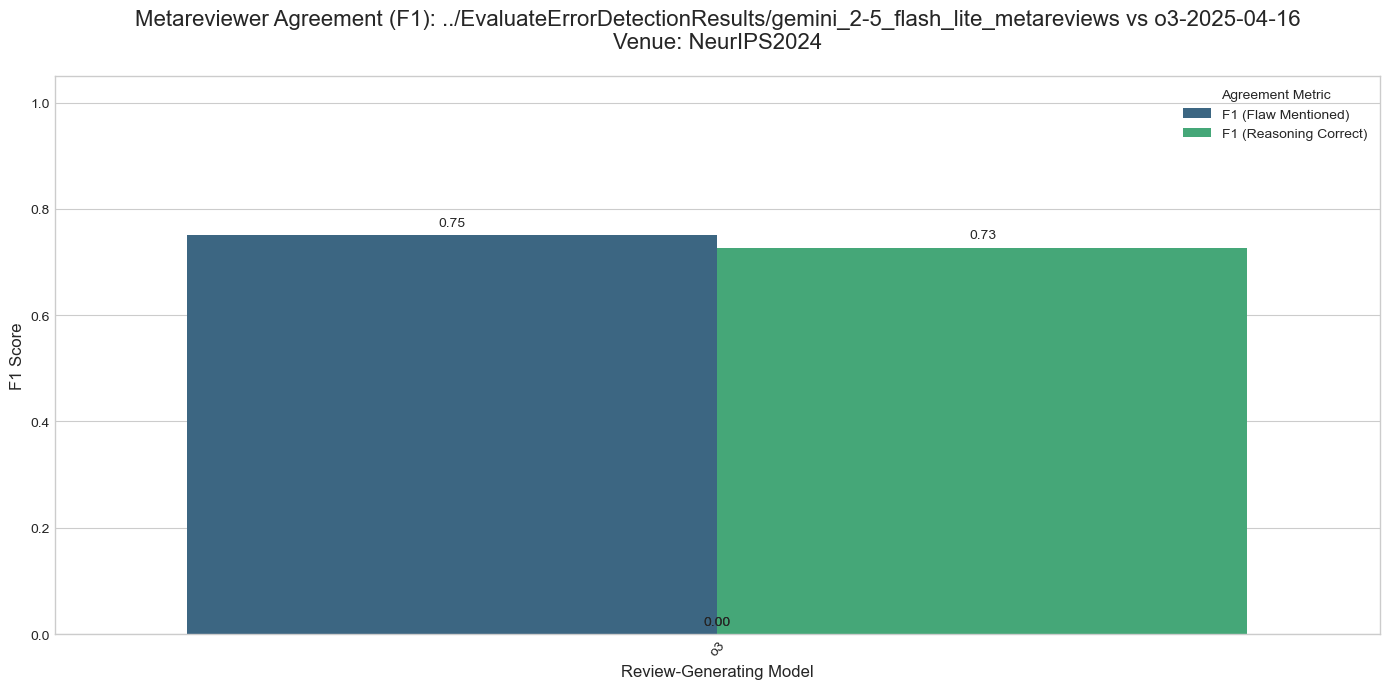

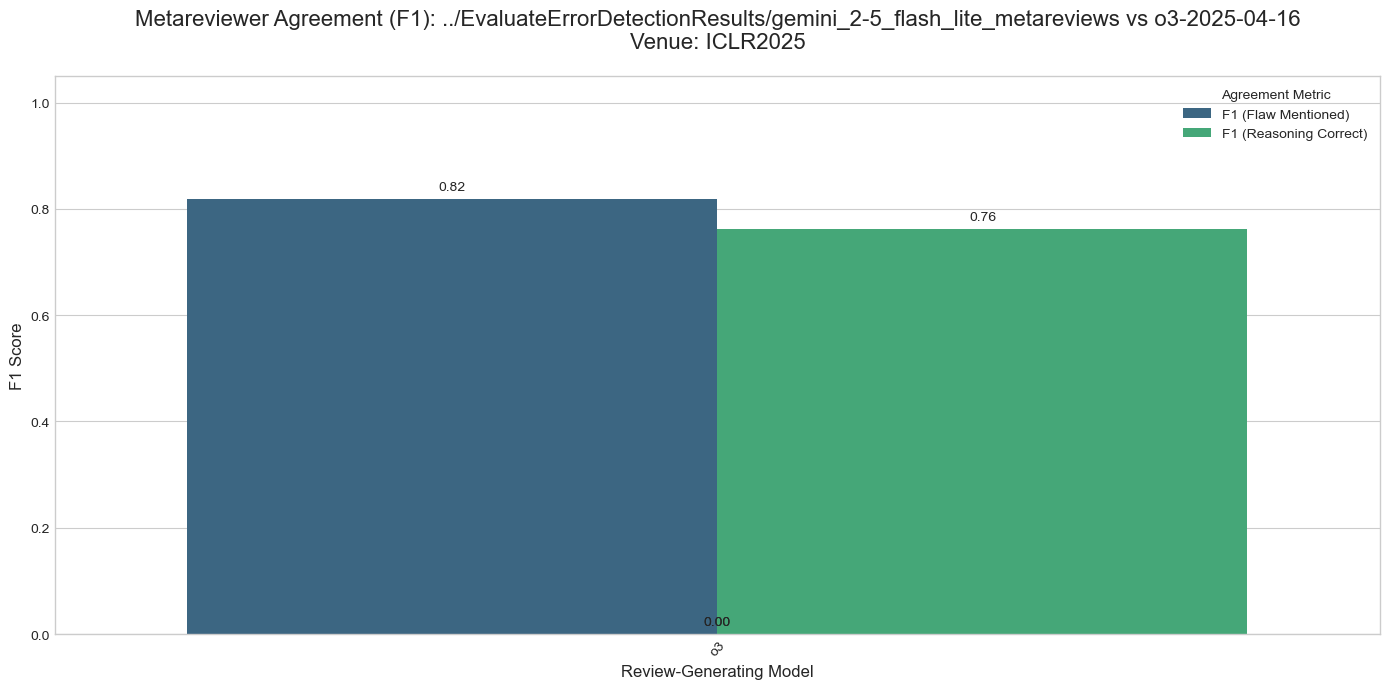

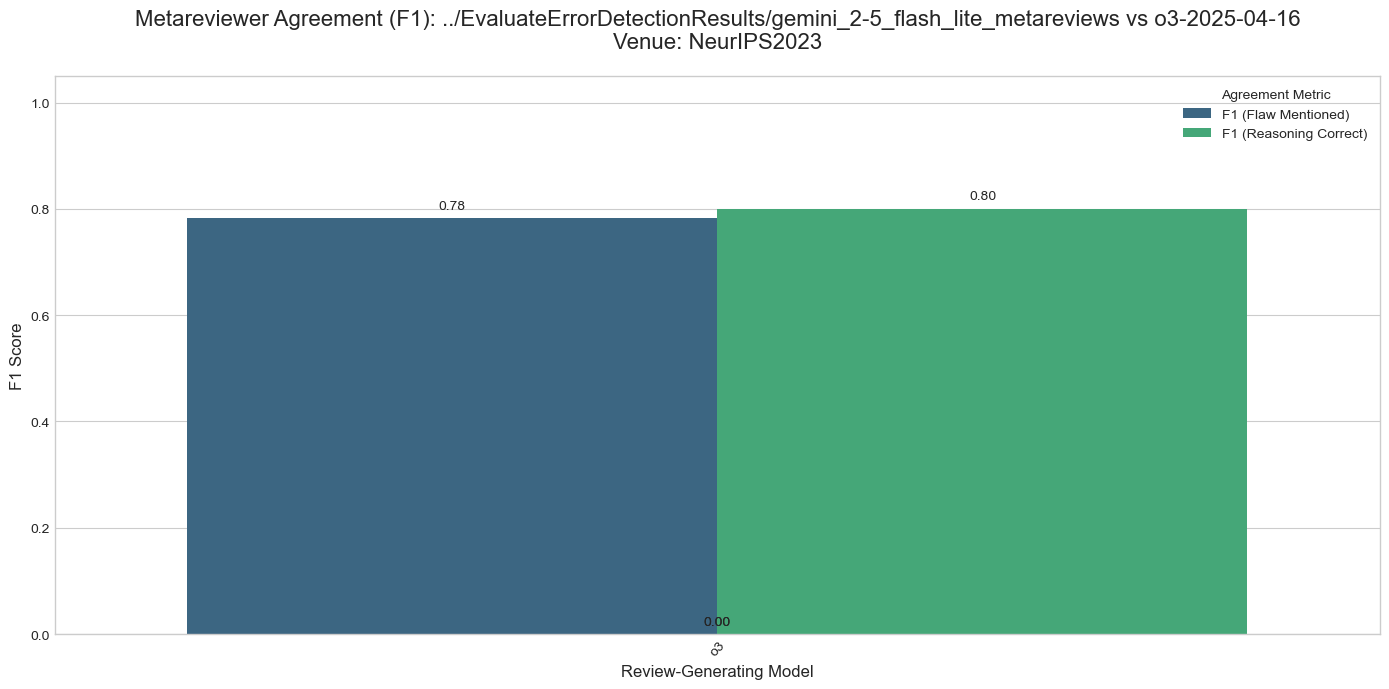

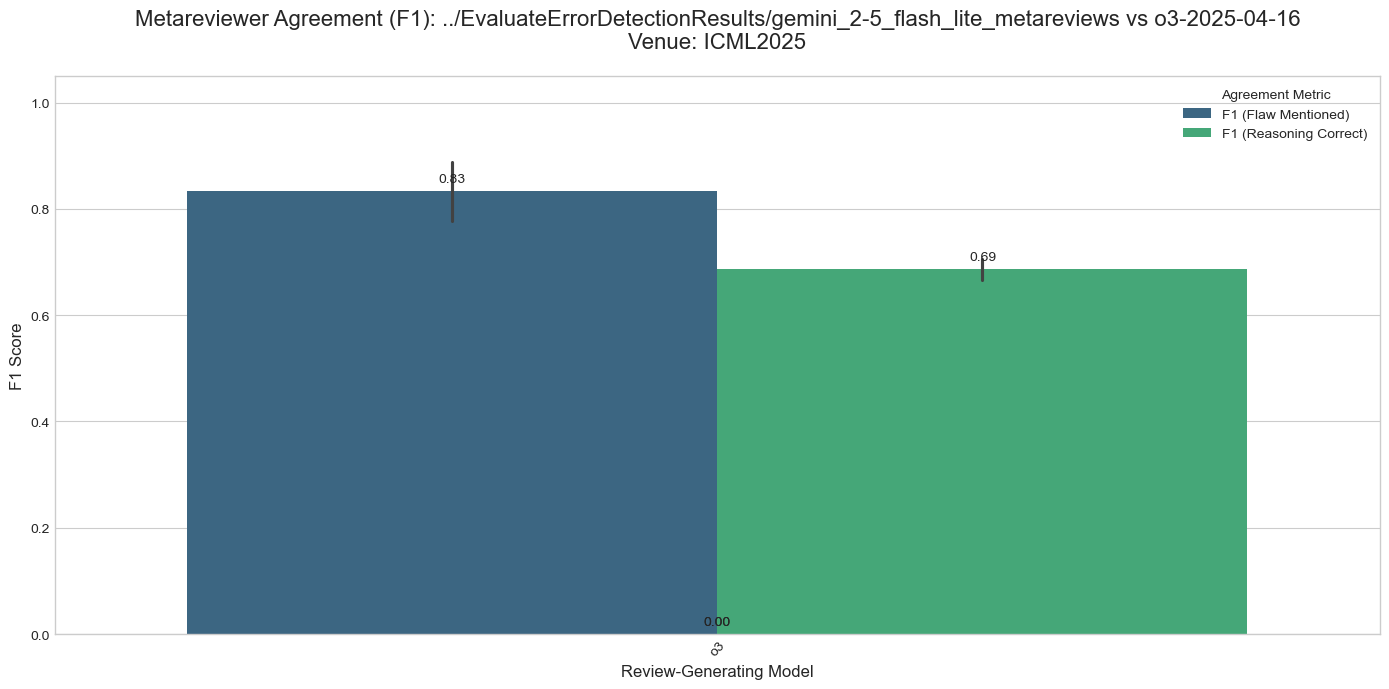

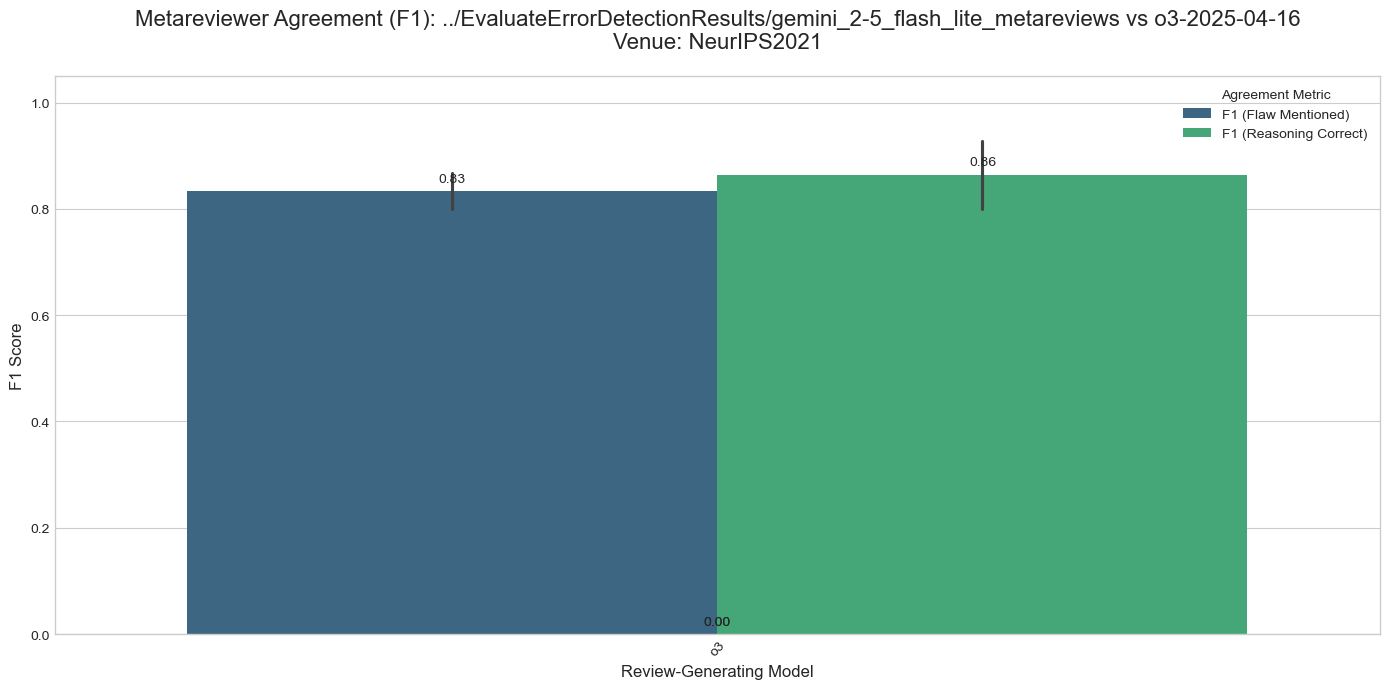

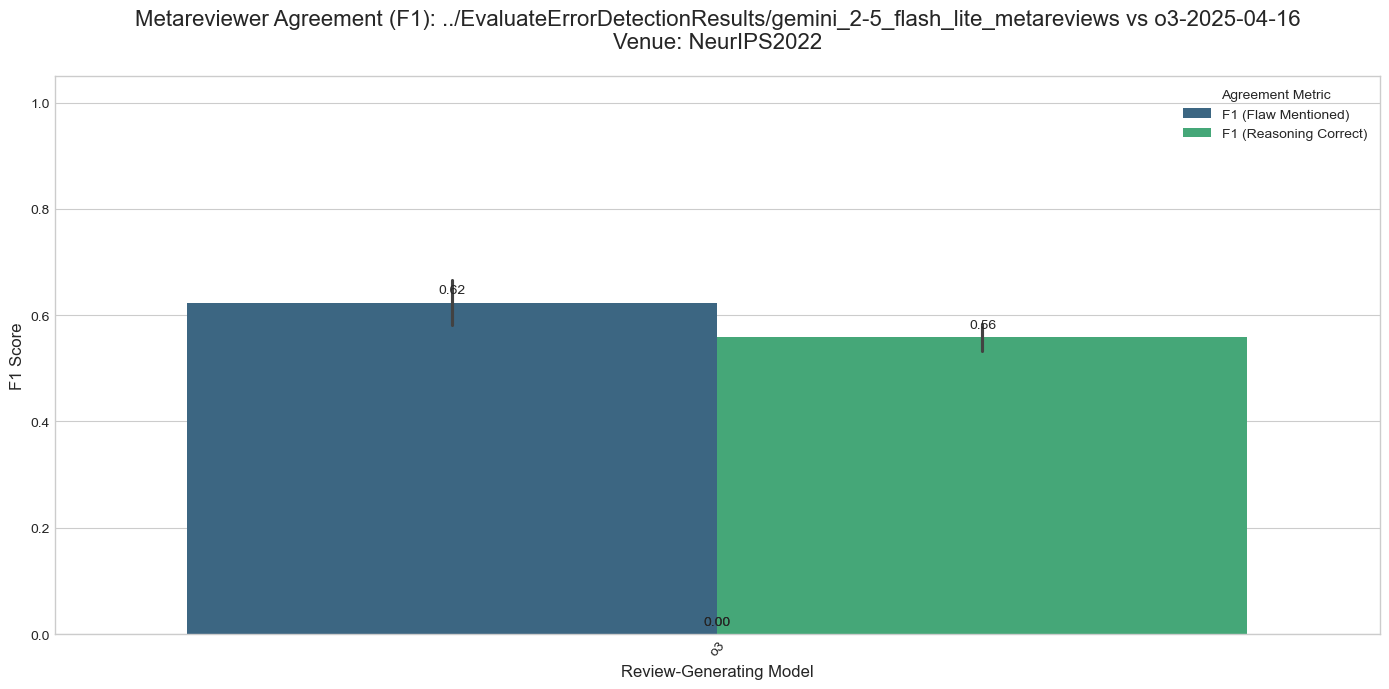

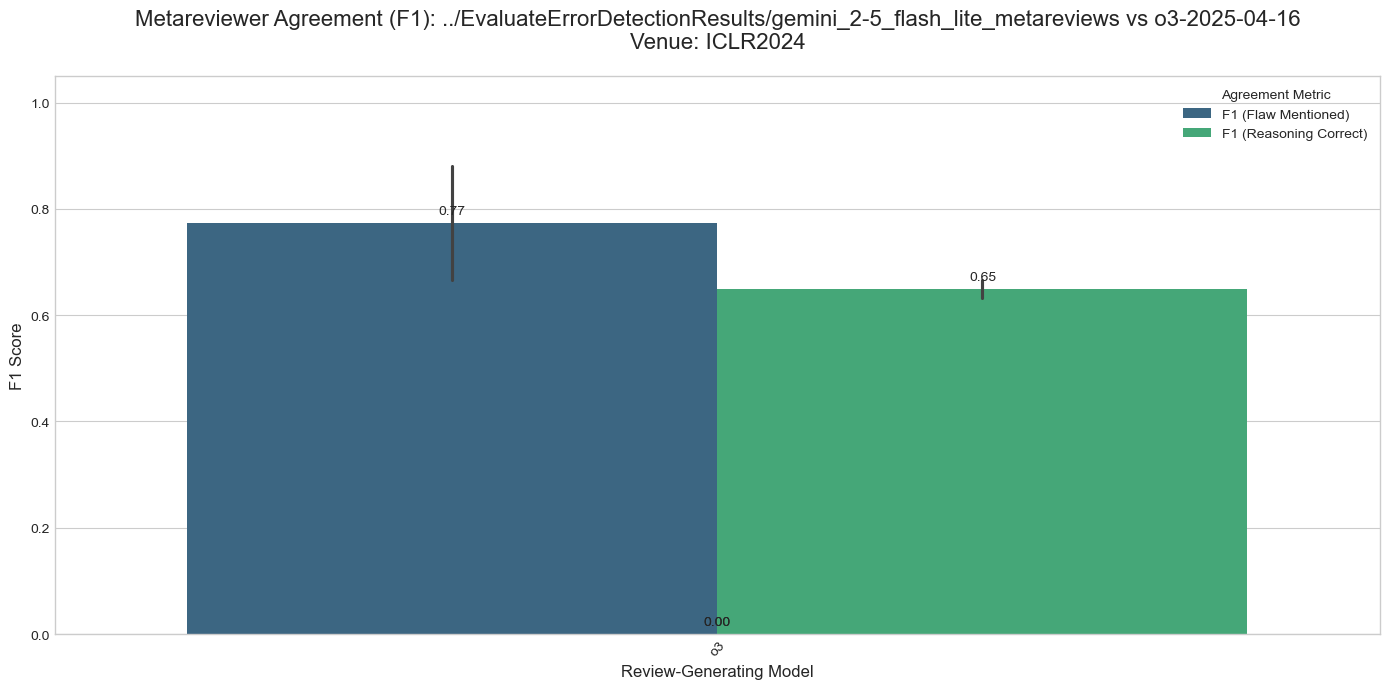

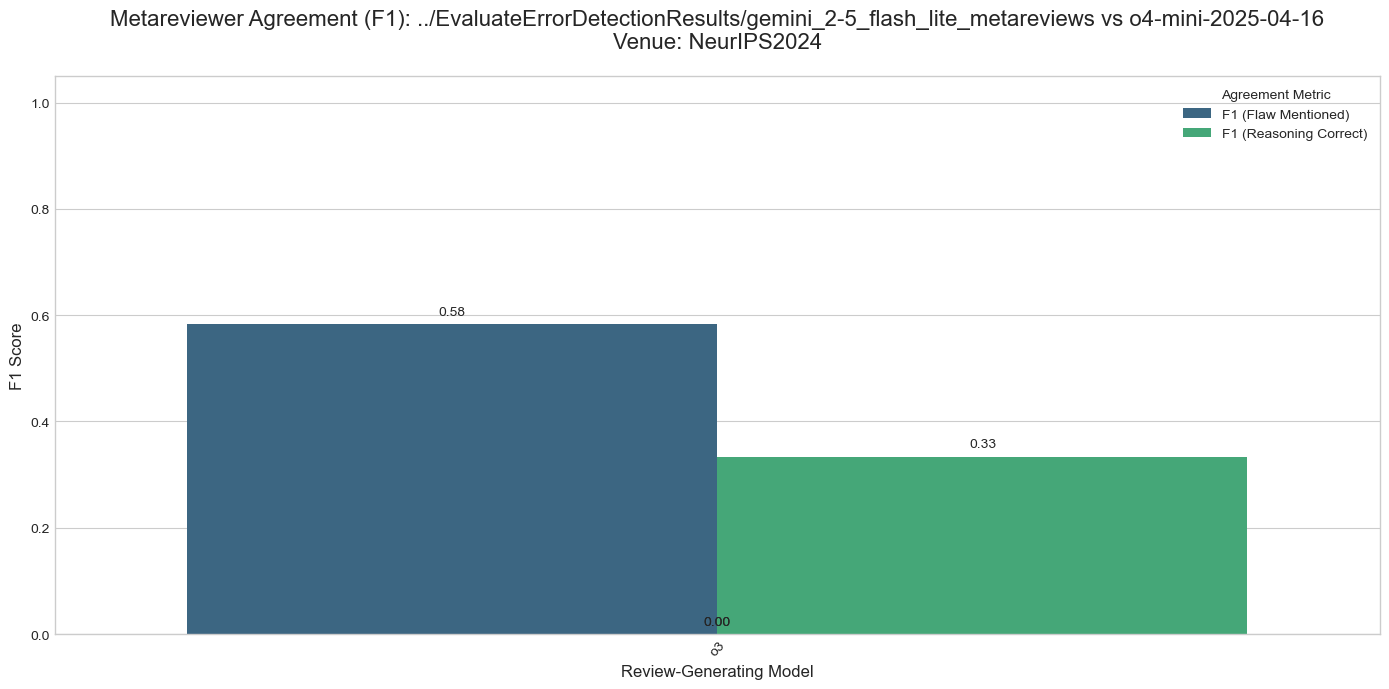

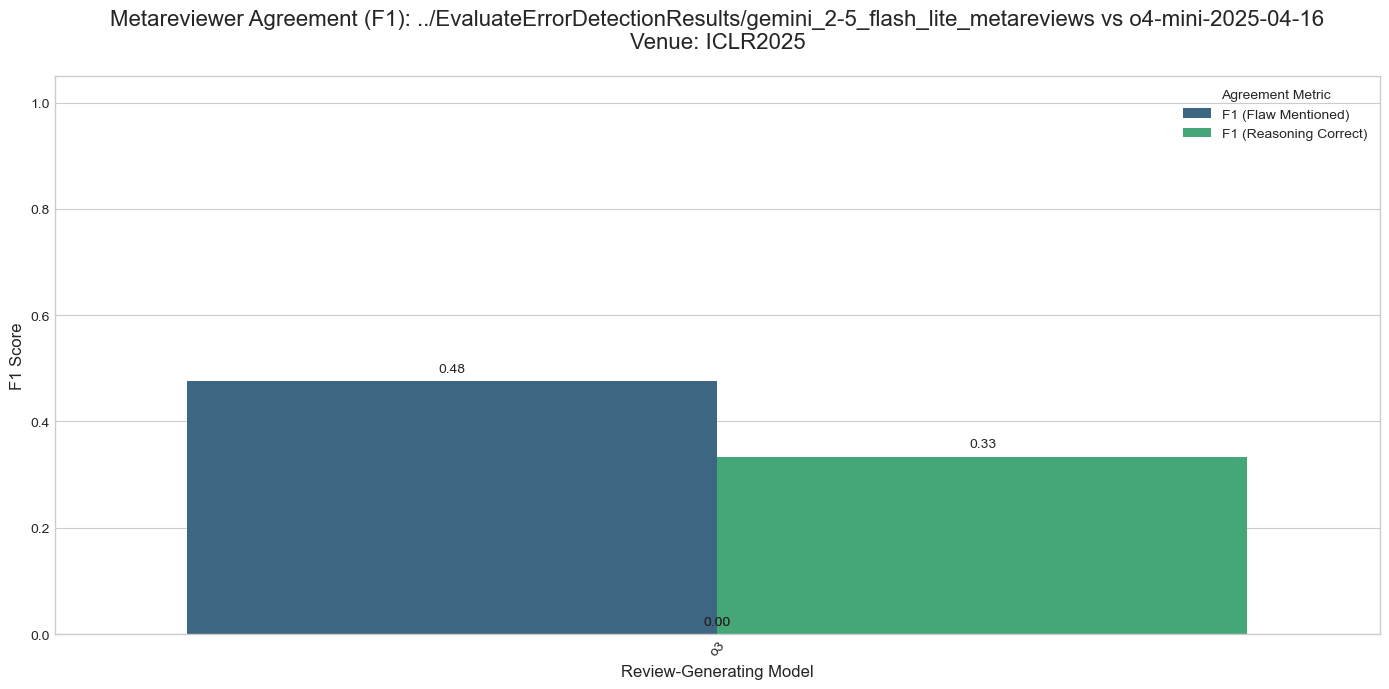

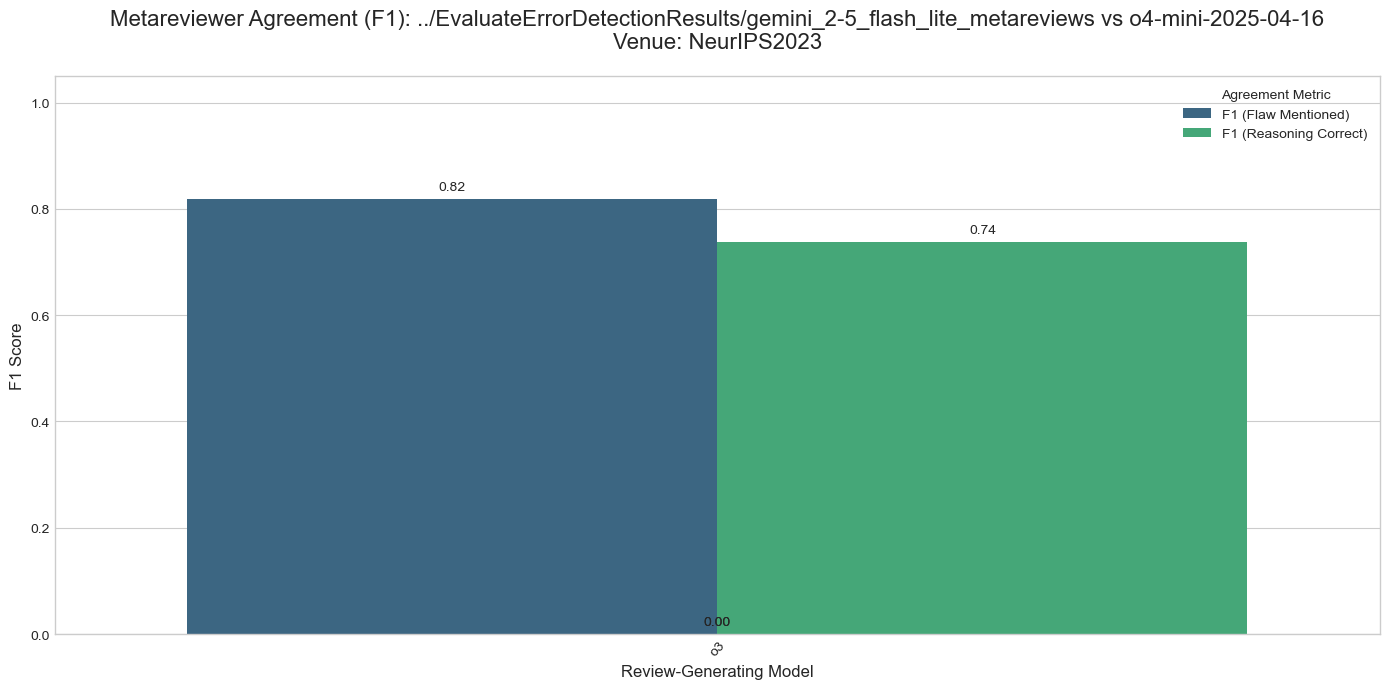

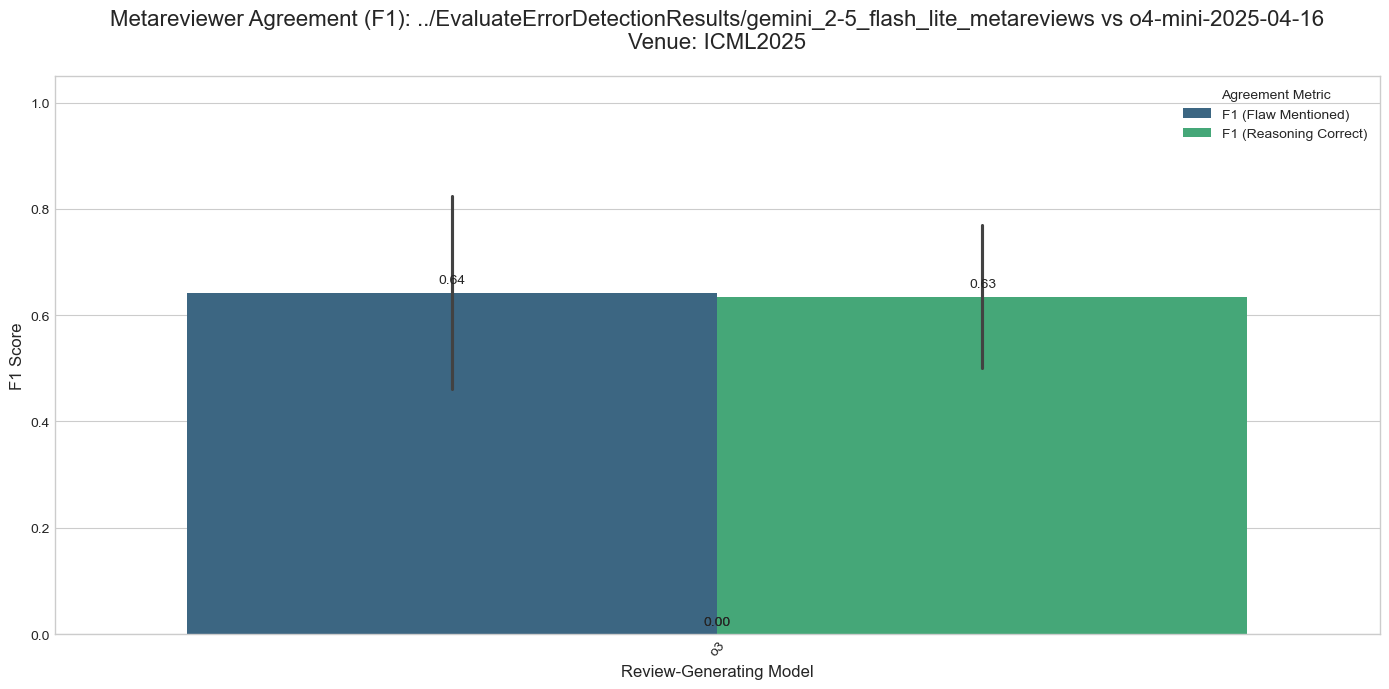

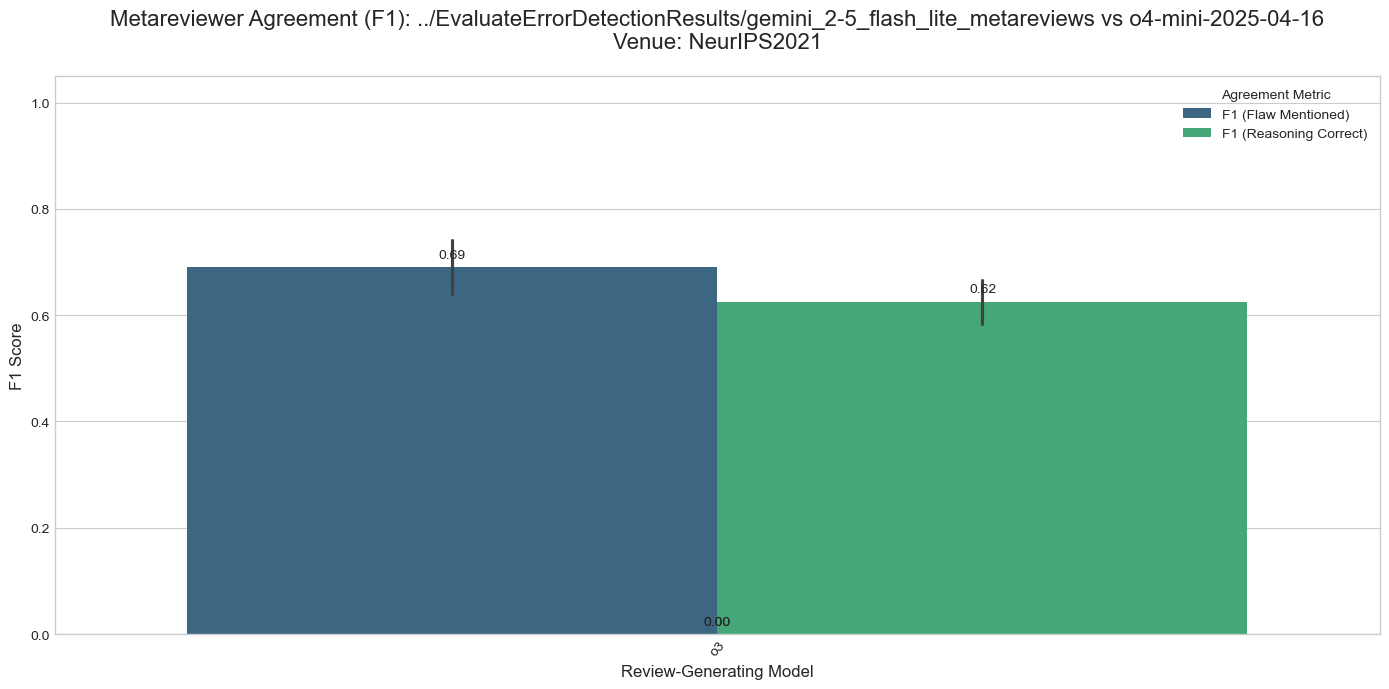

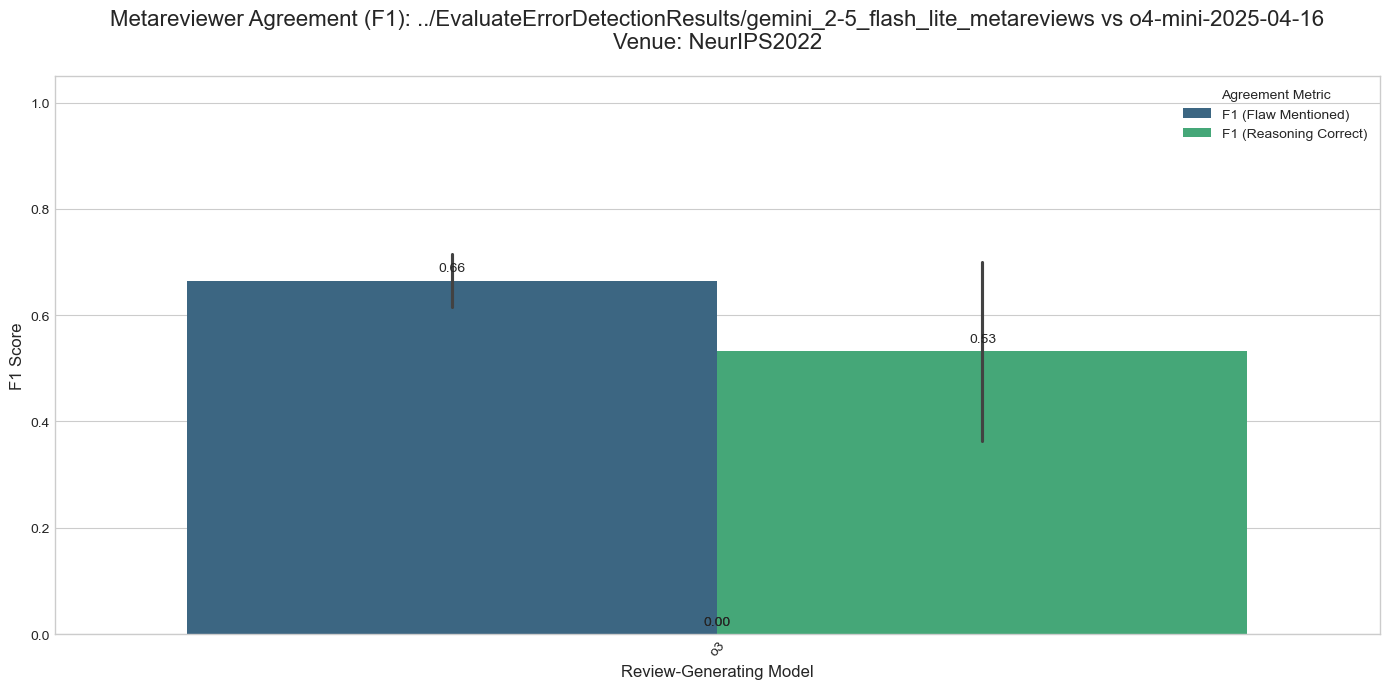

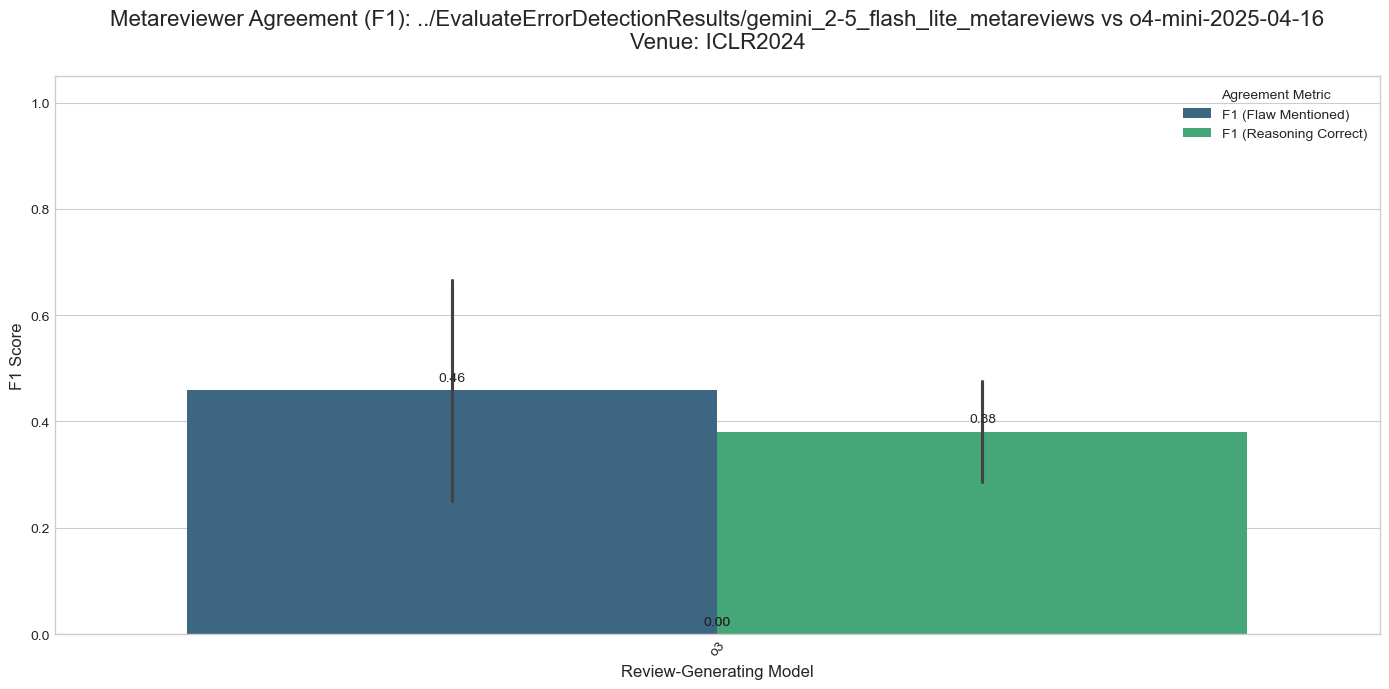

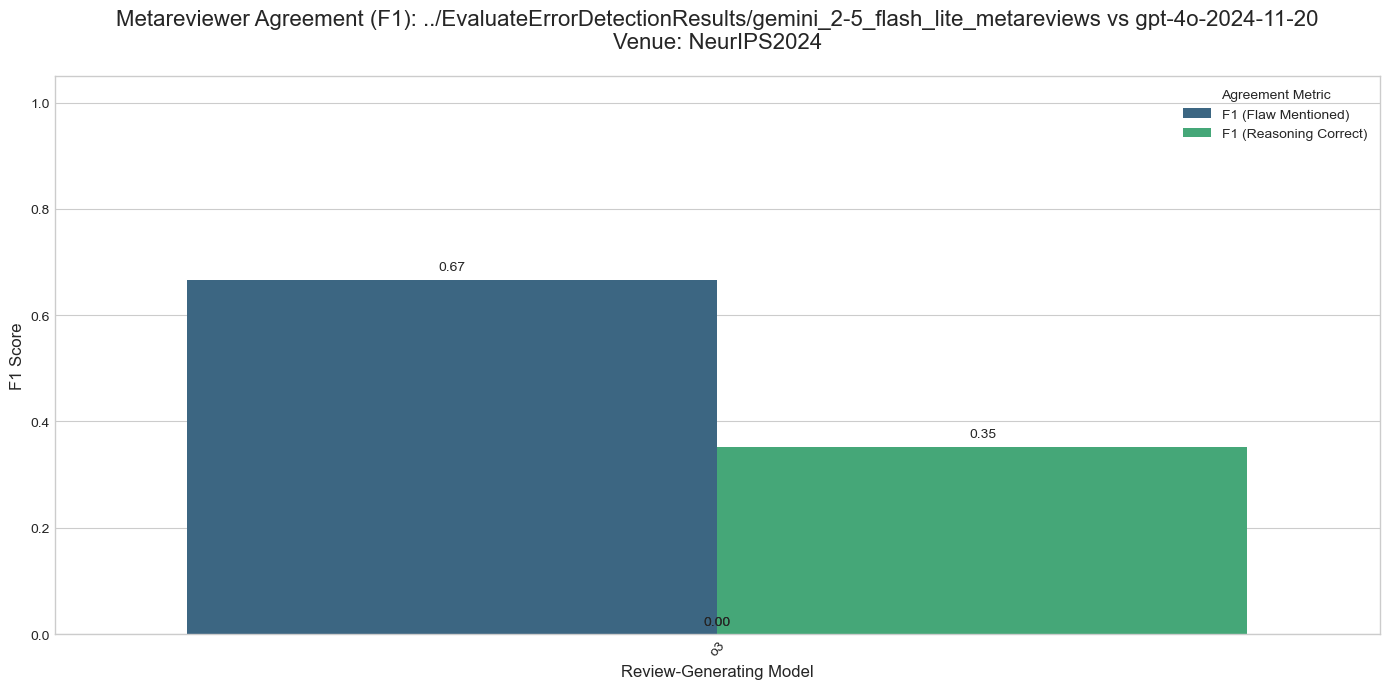

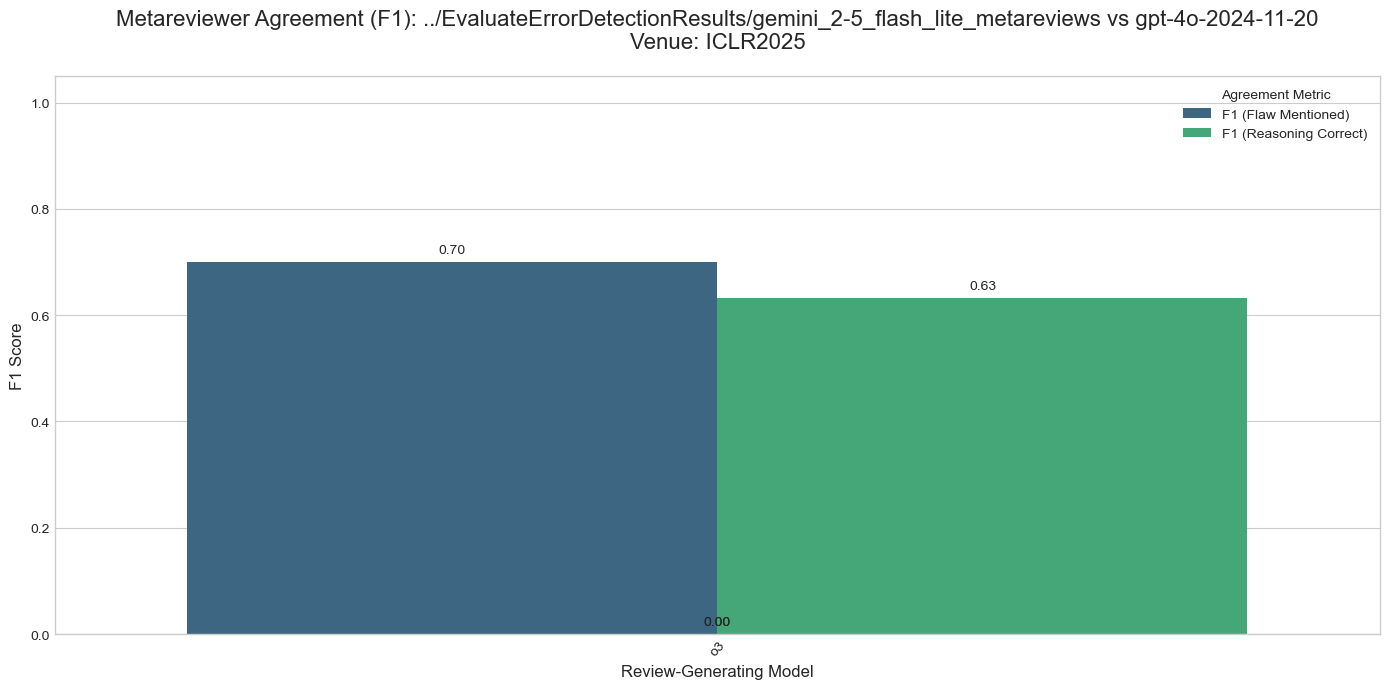

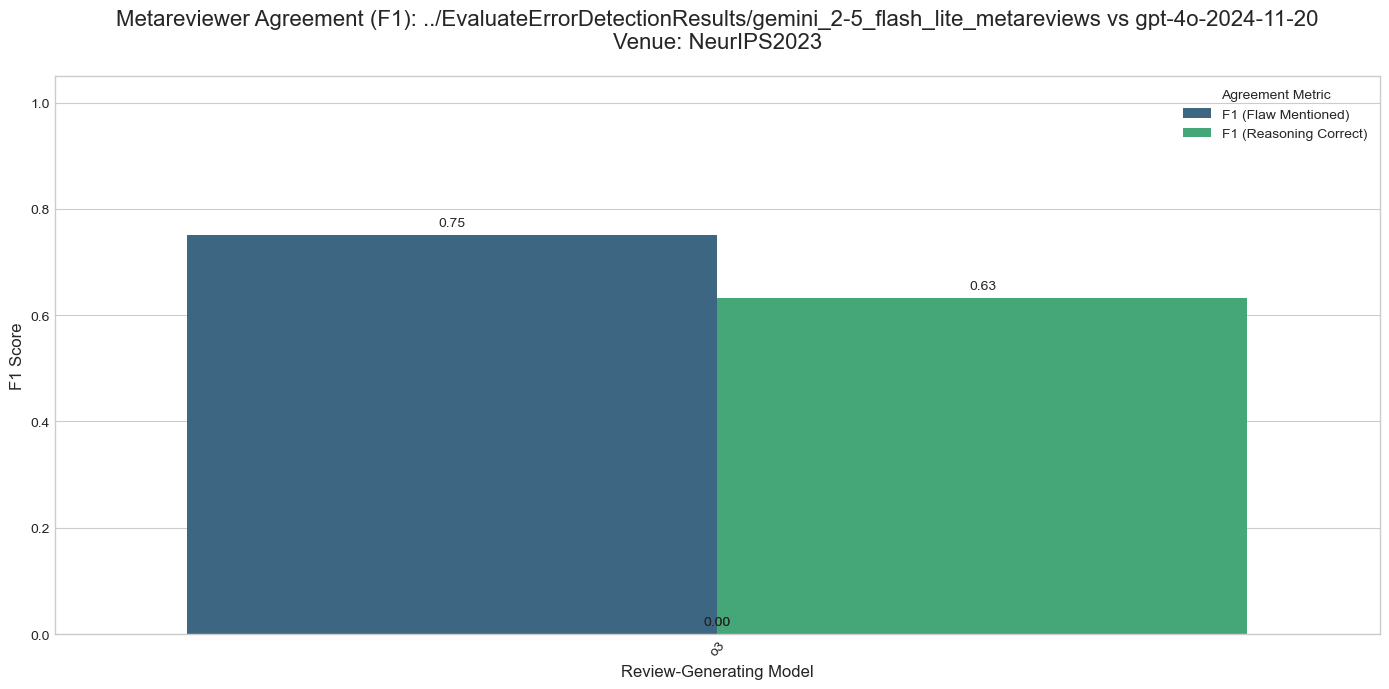

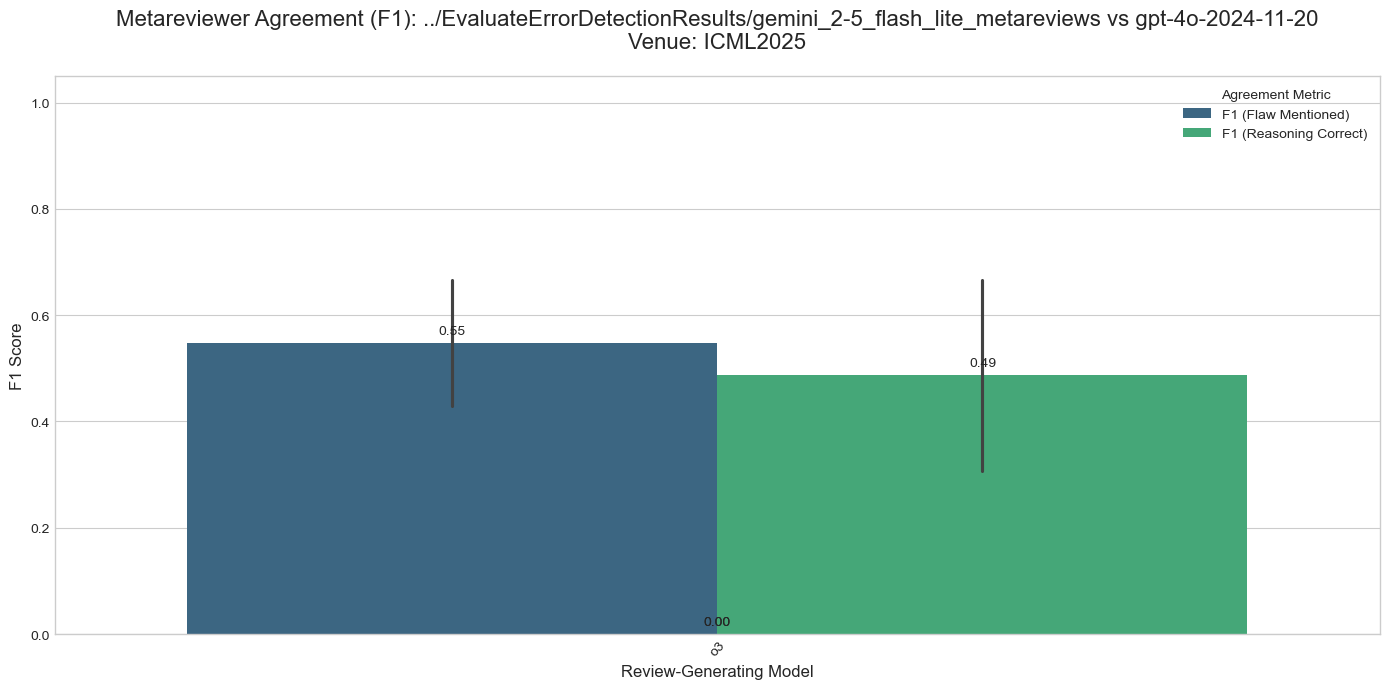

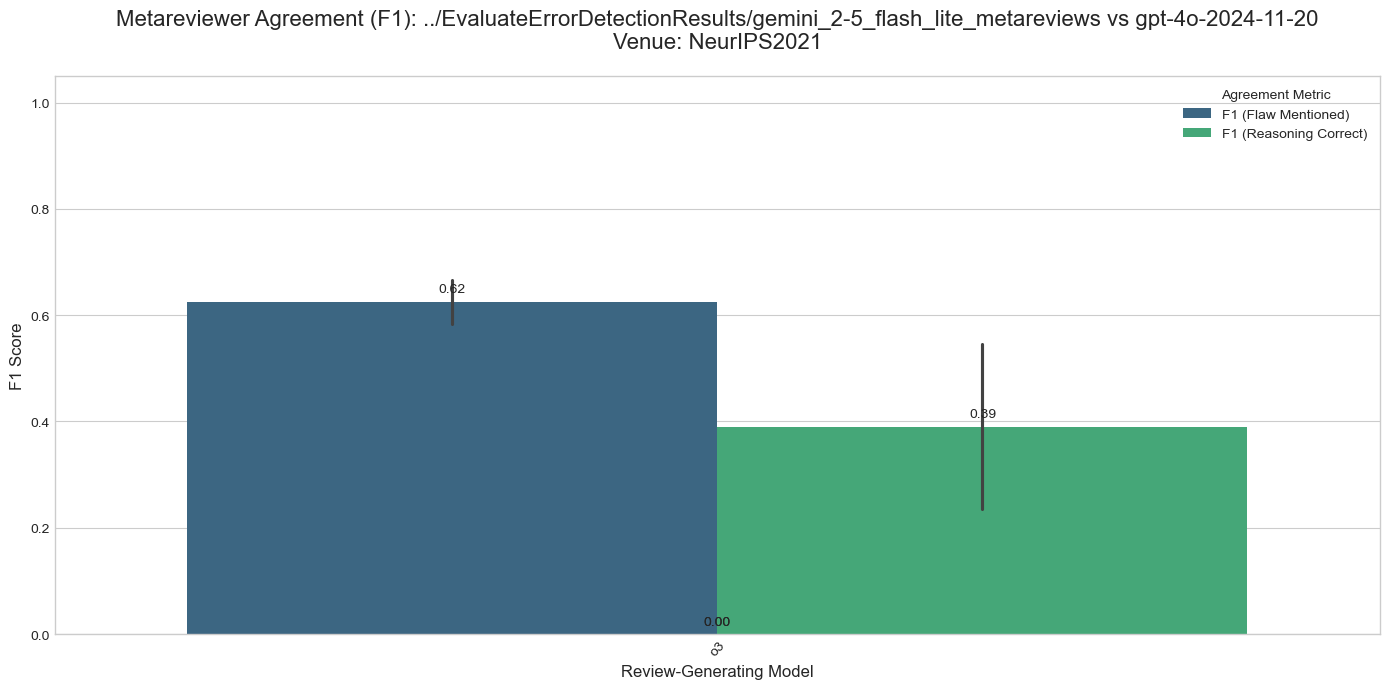

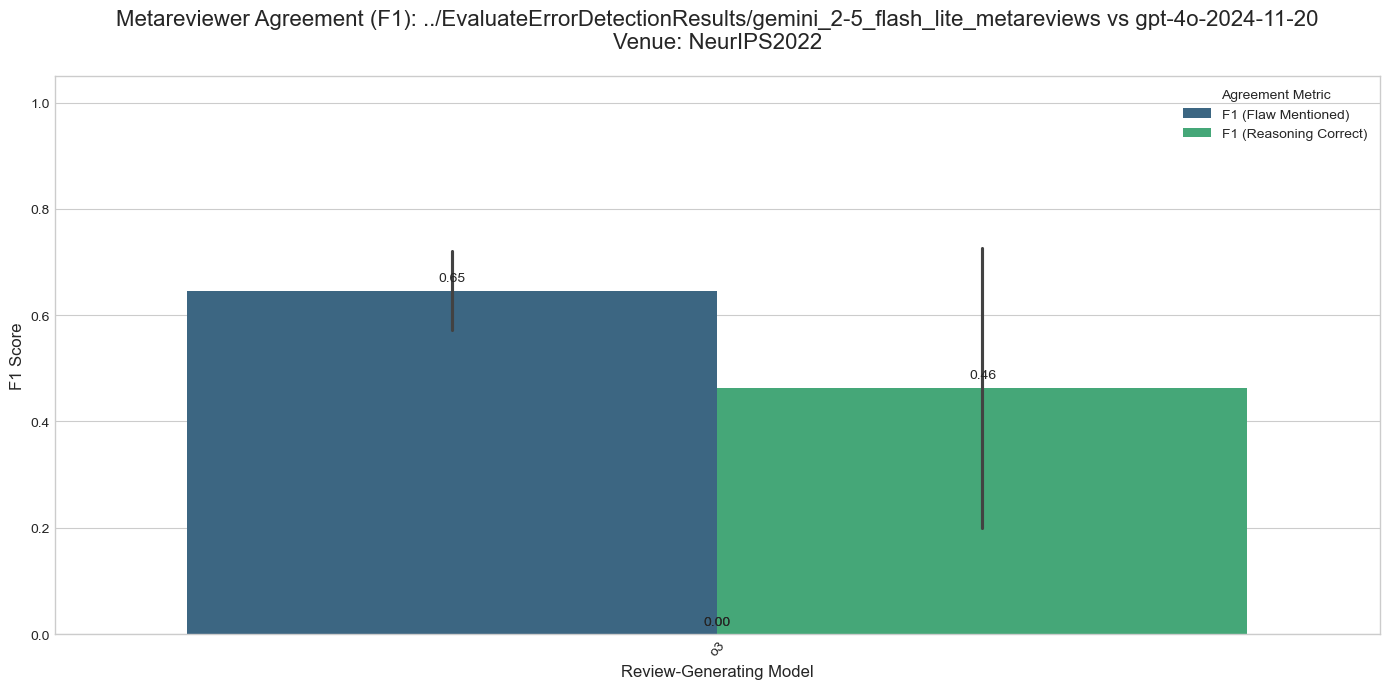

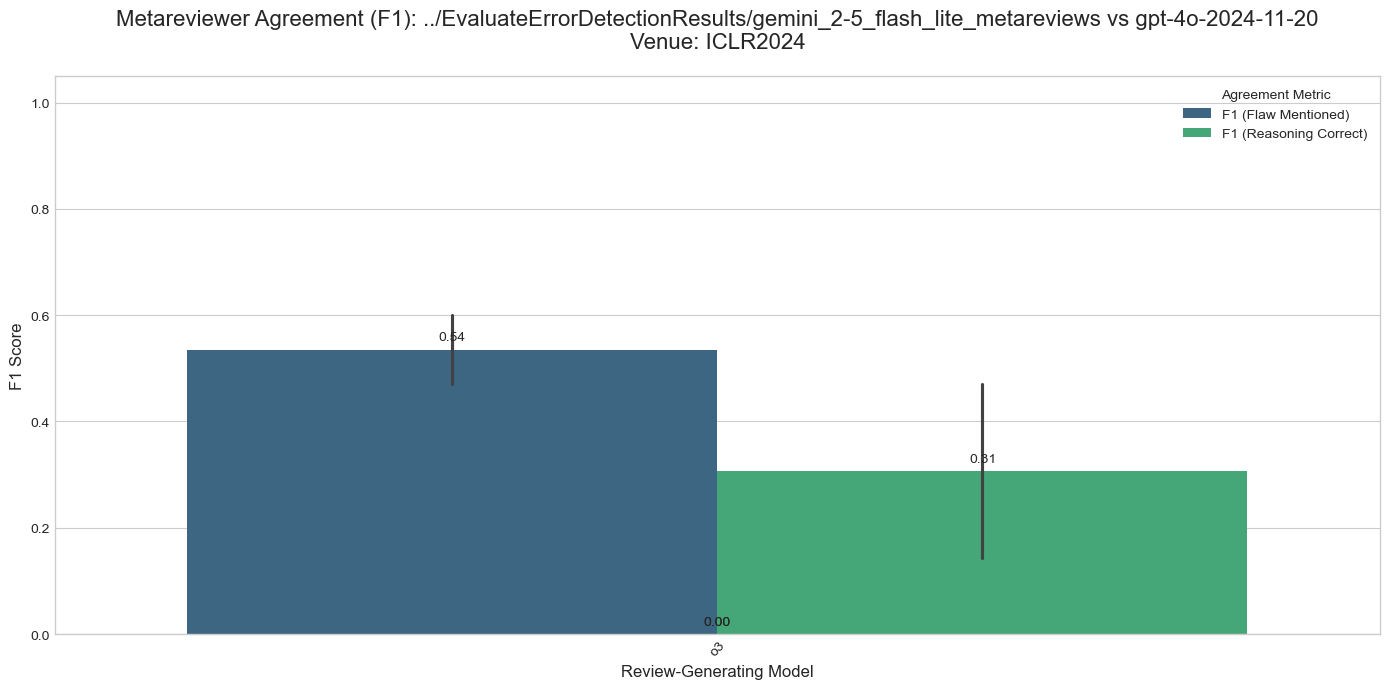

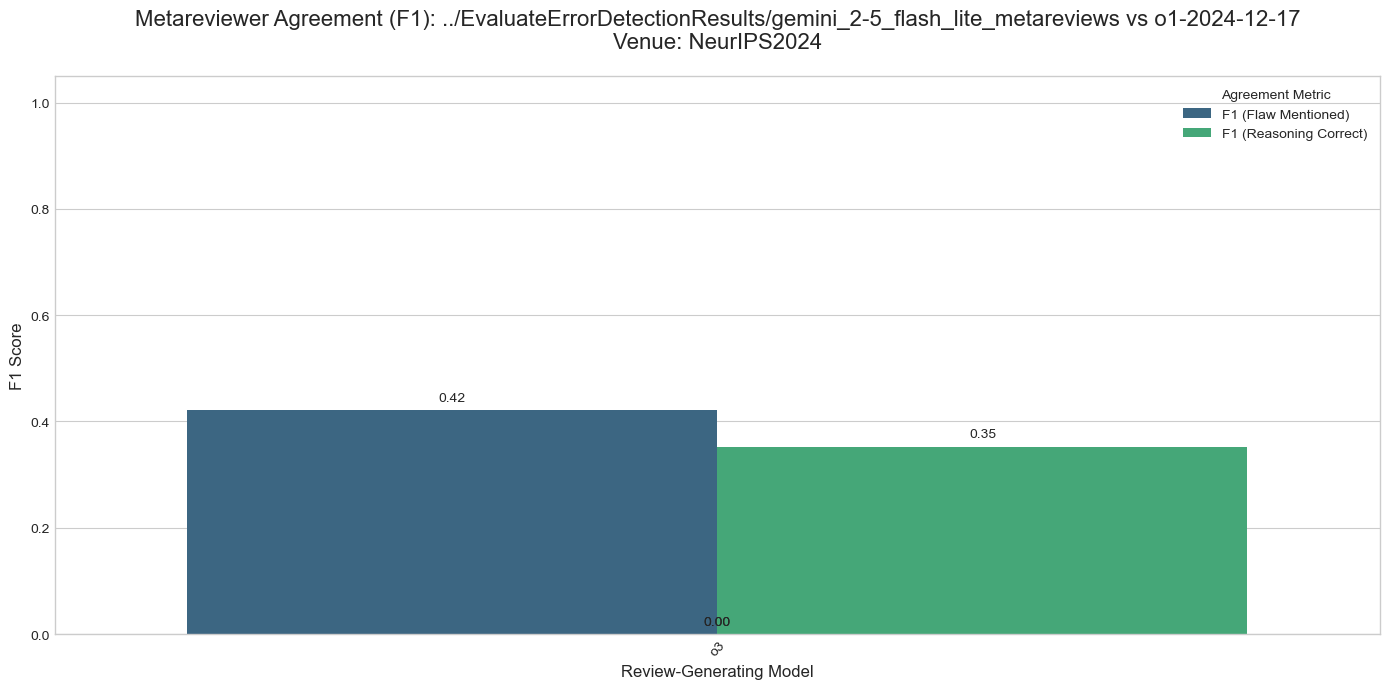

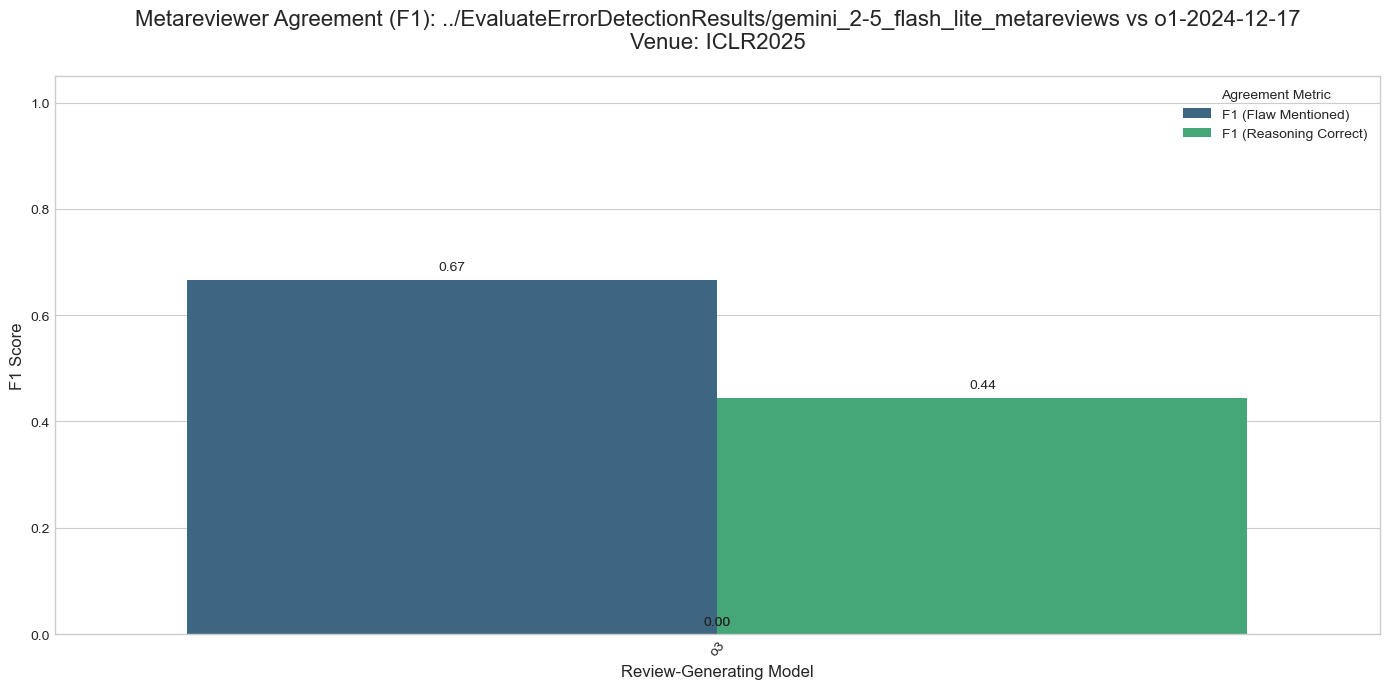

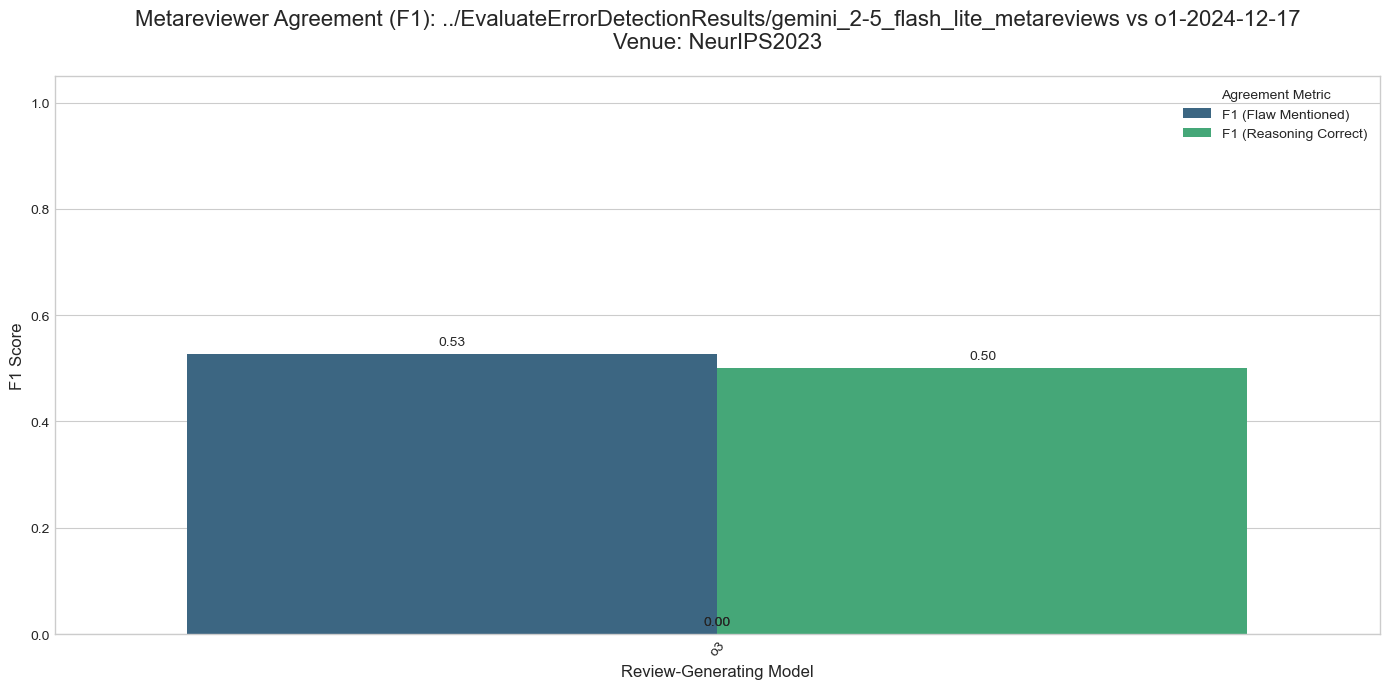

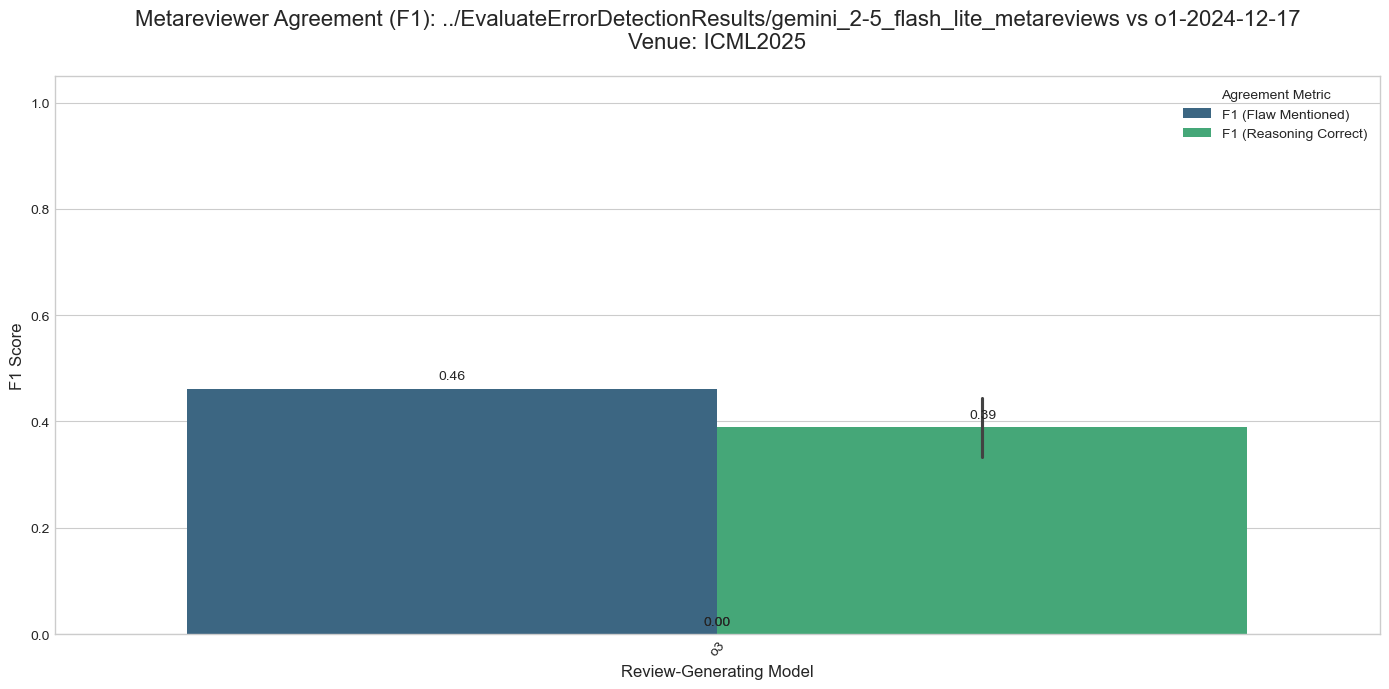

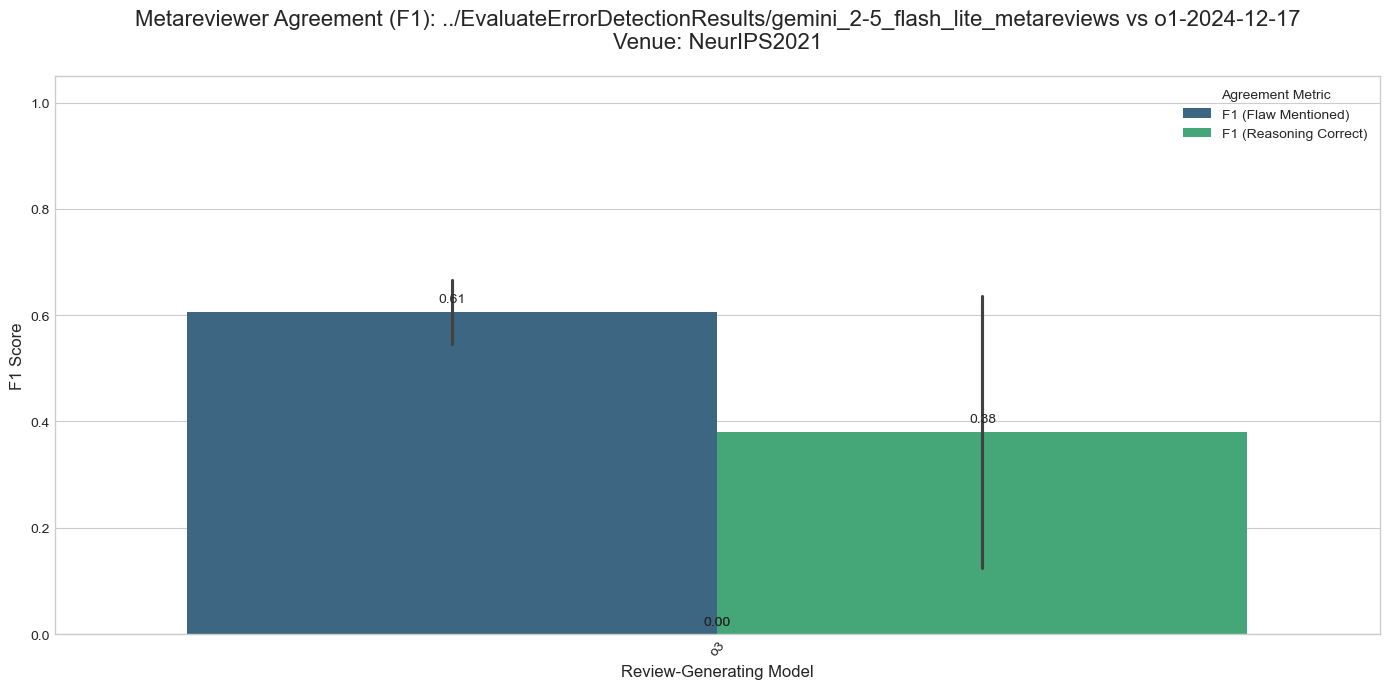

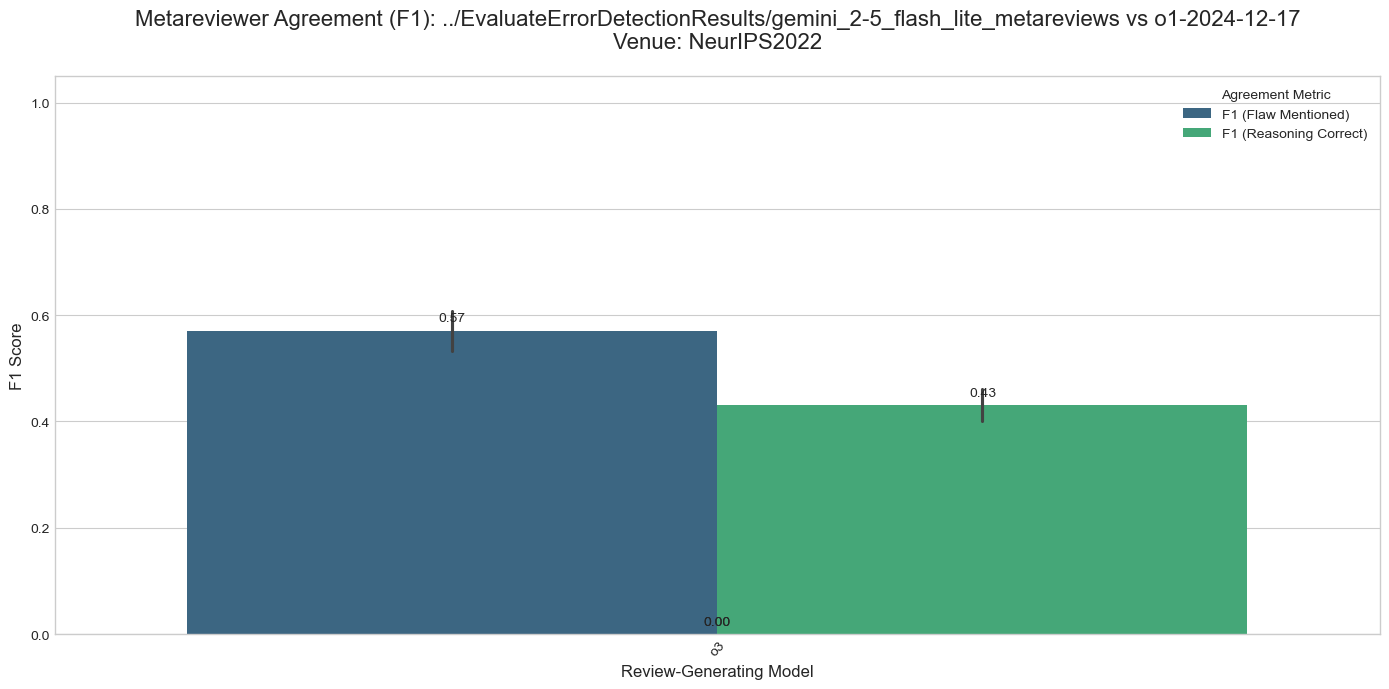

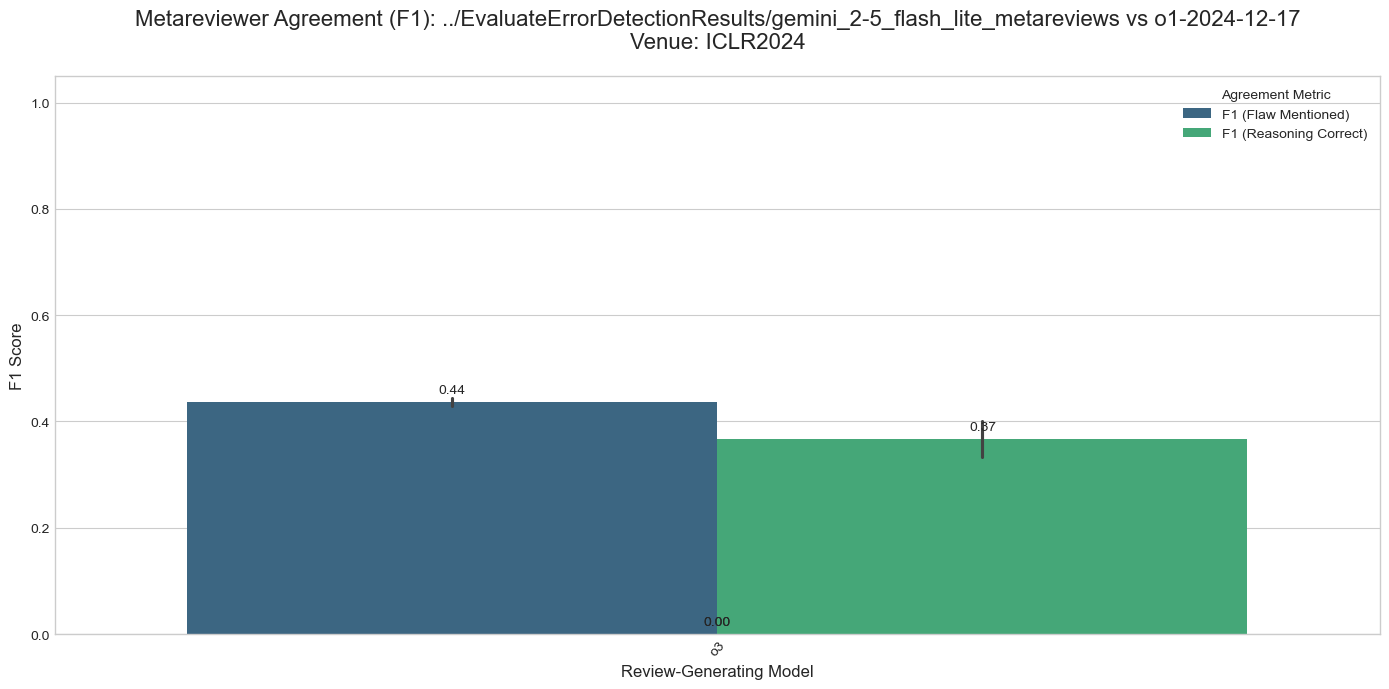


--- Accuracy Score Visualizations ---


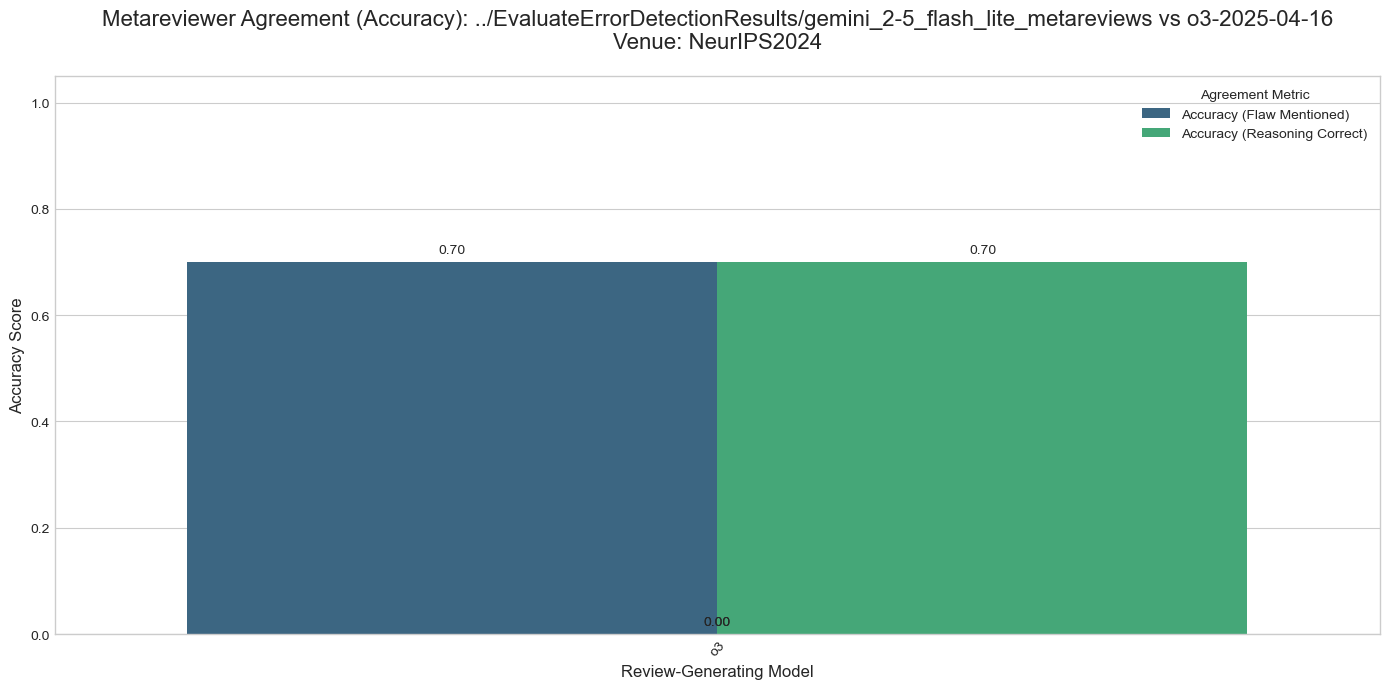

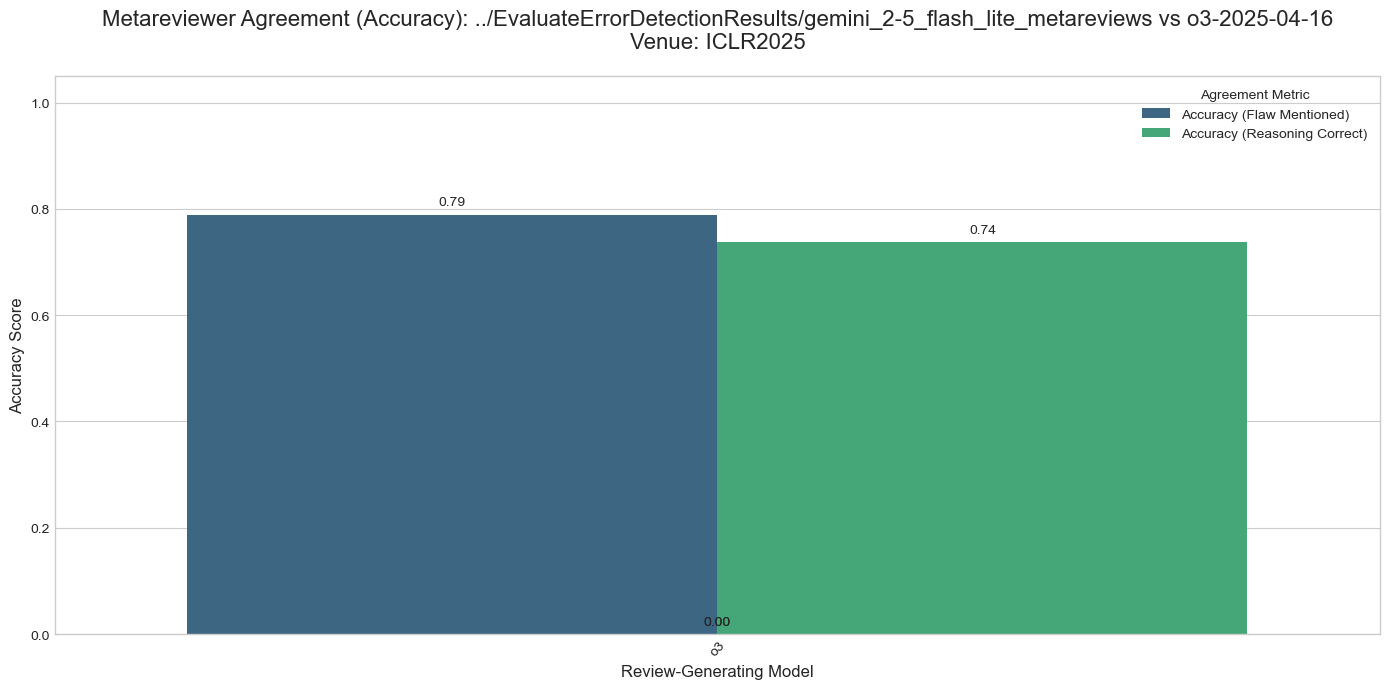

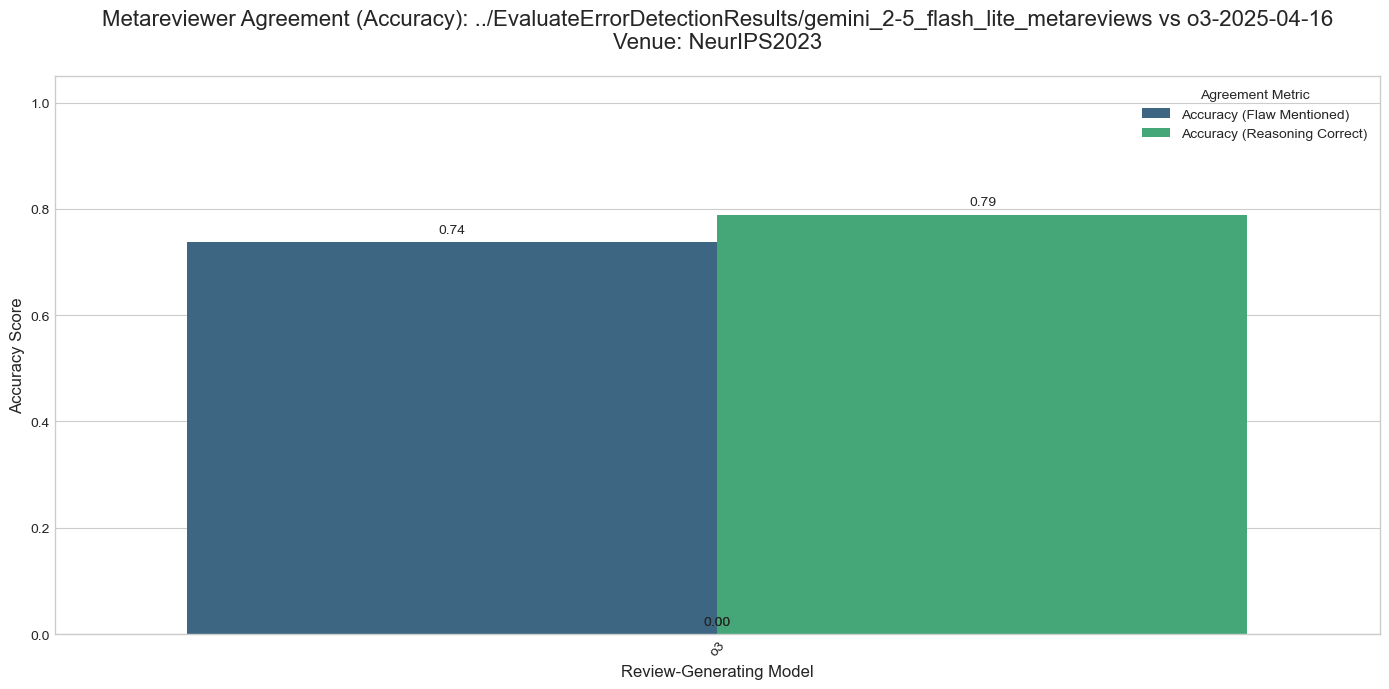

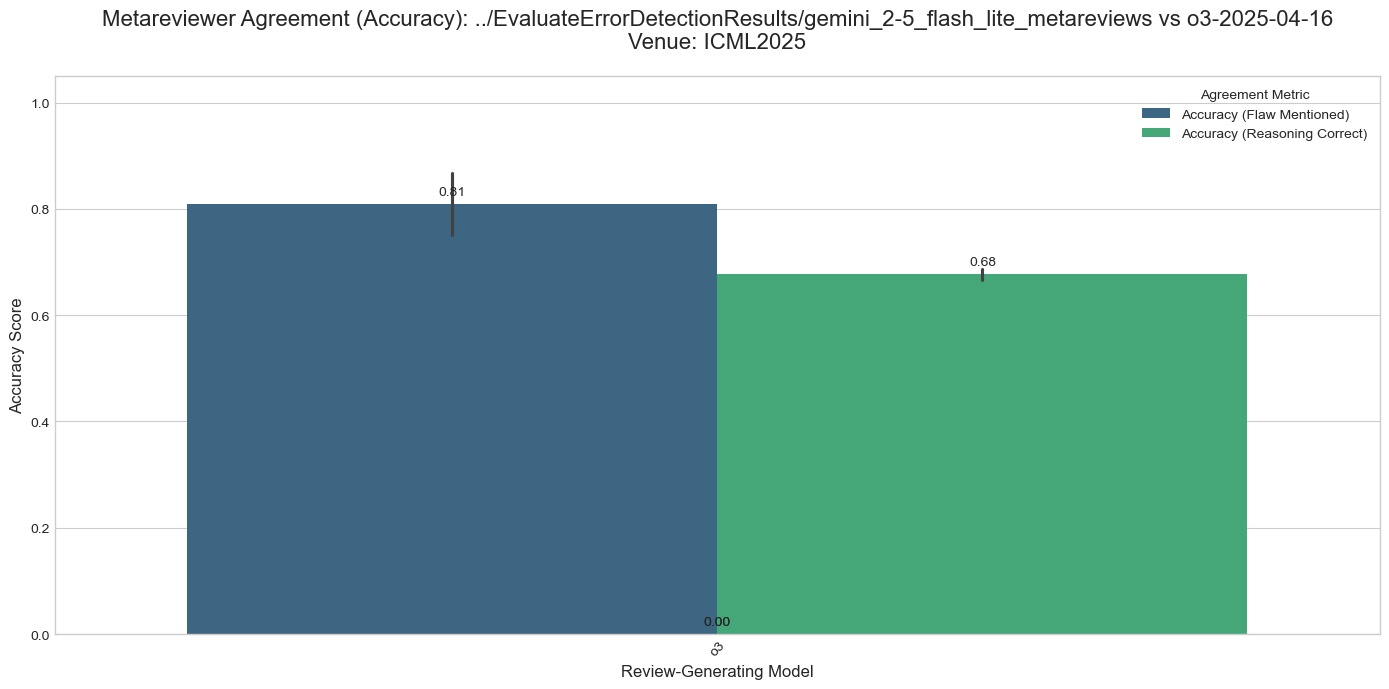

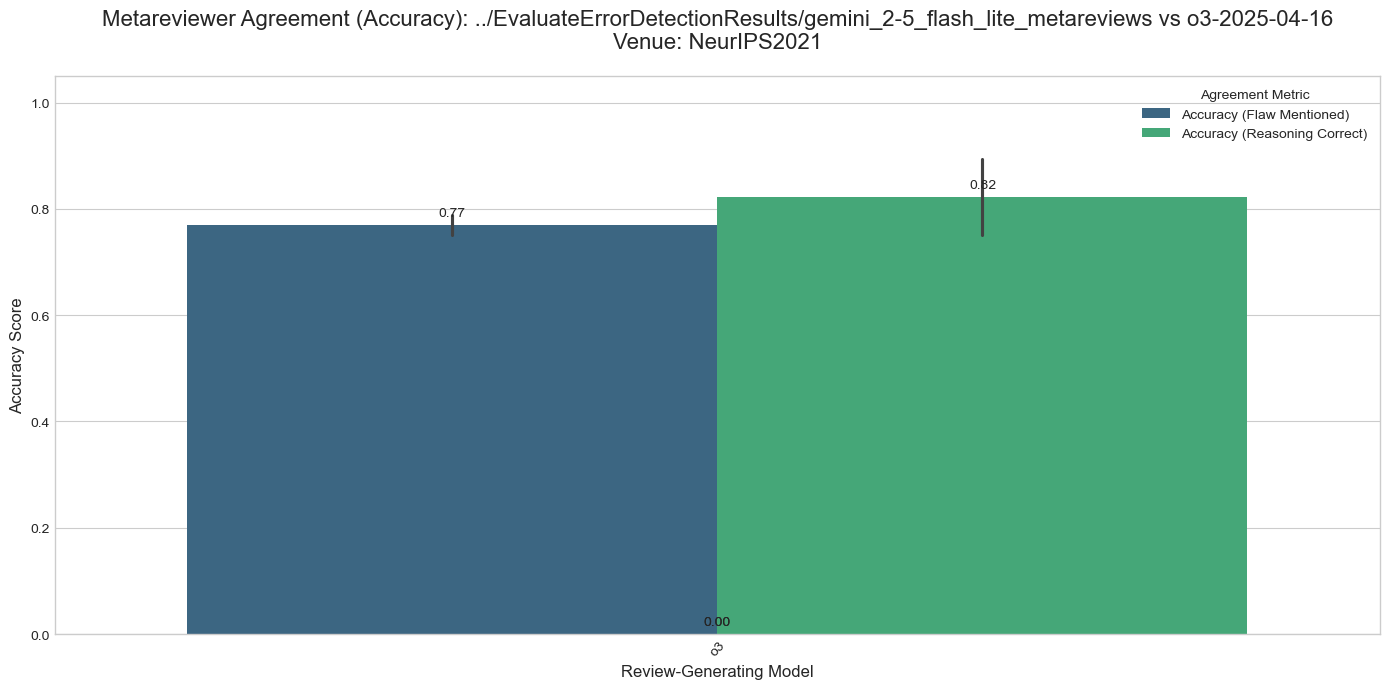

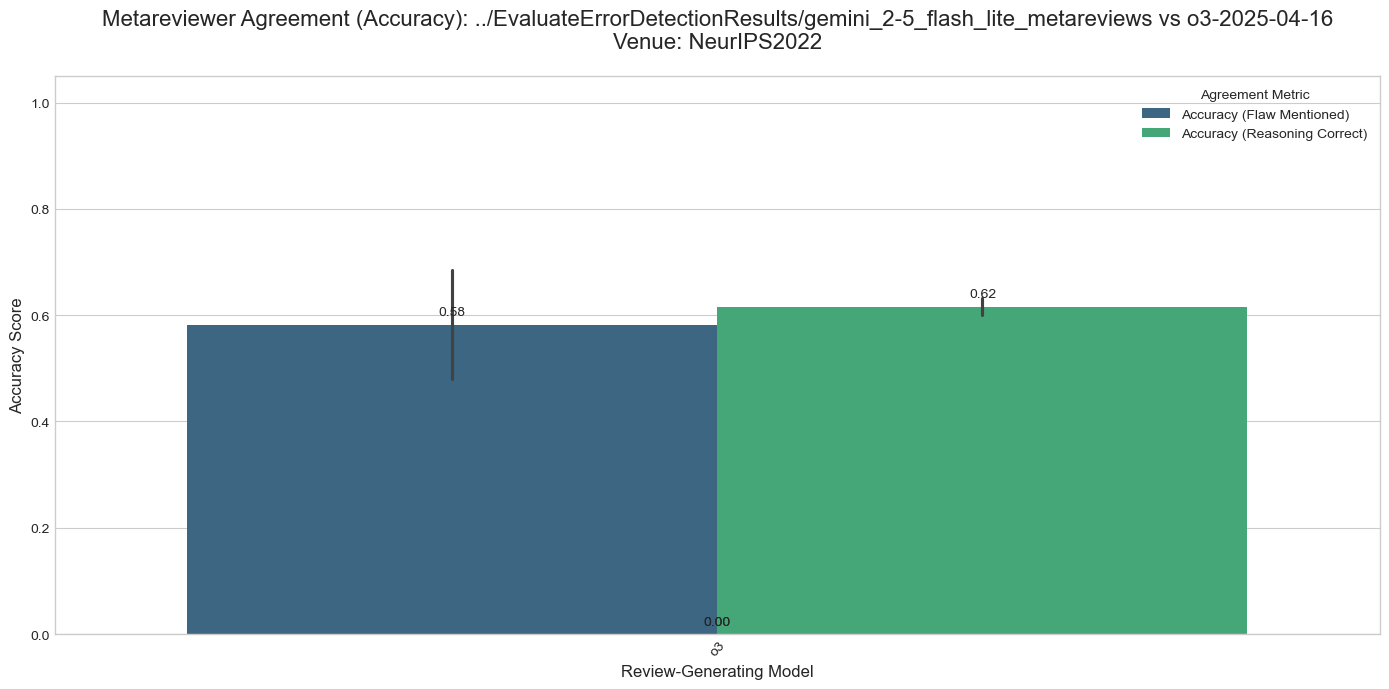

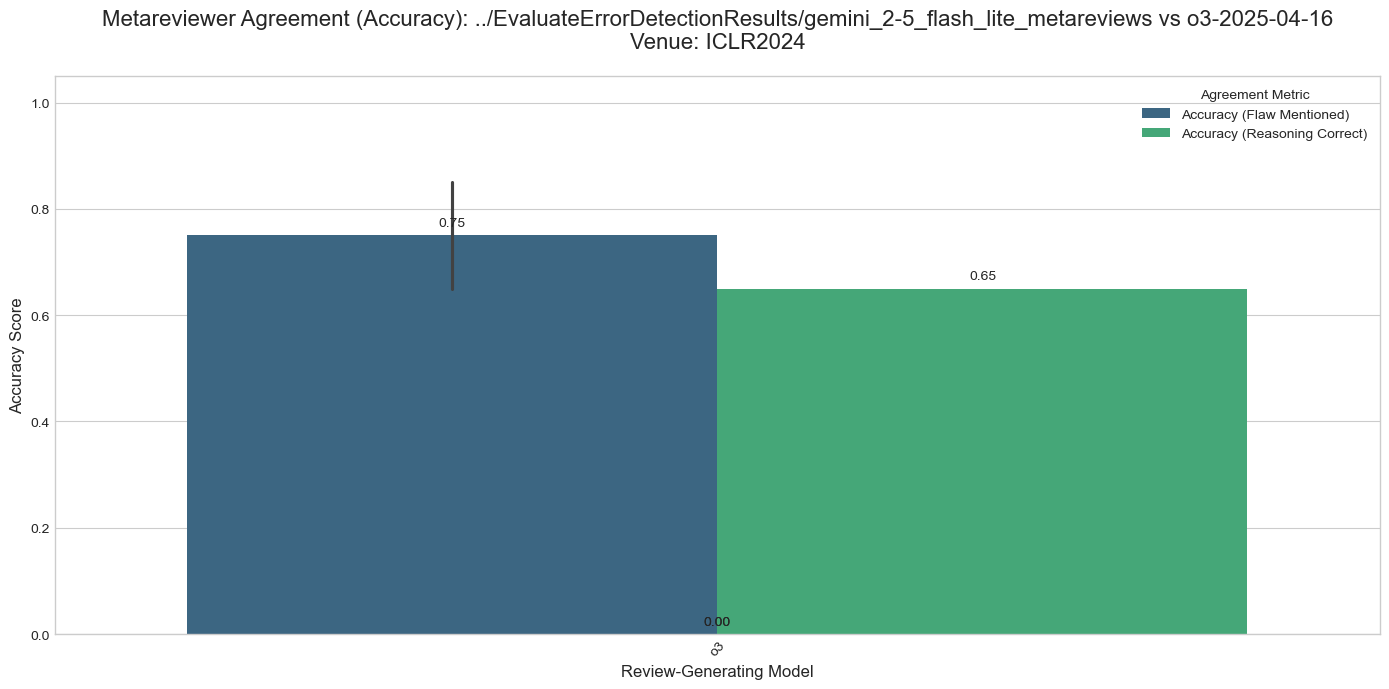

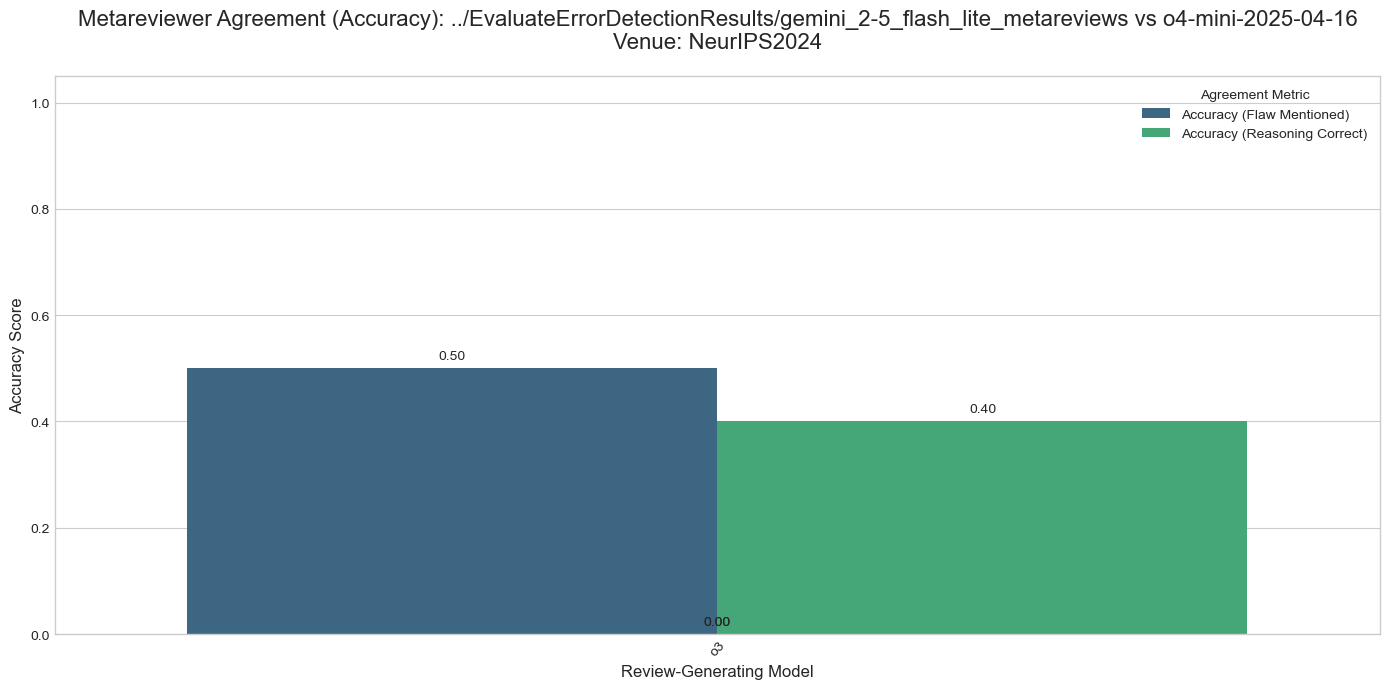

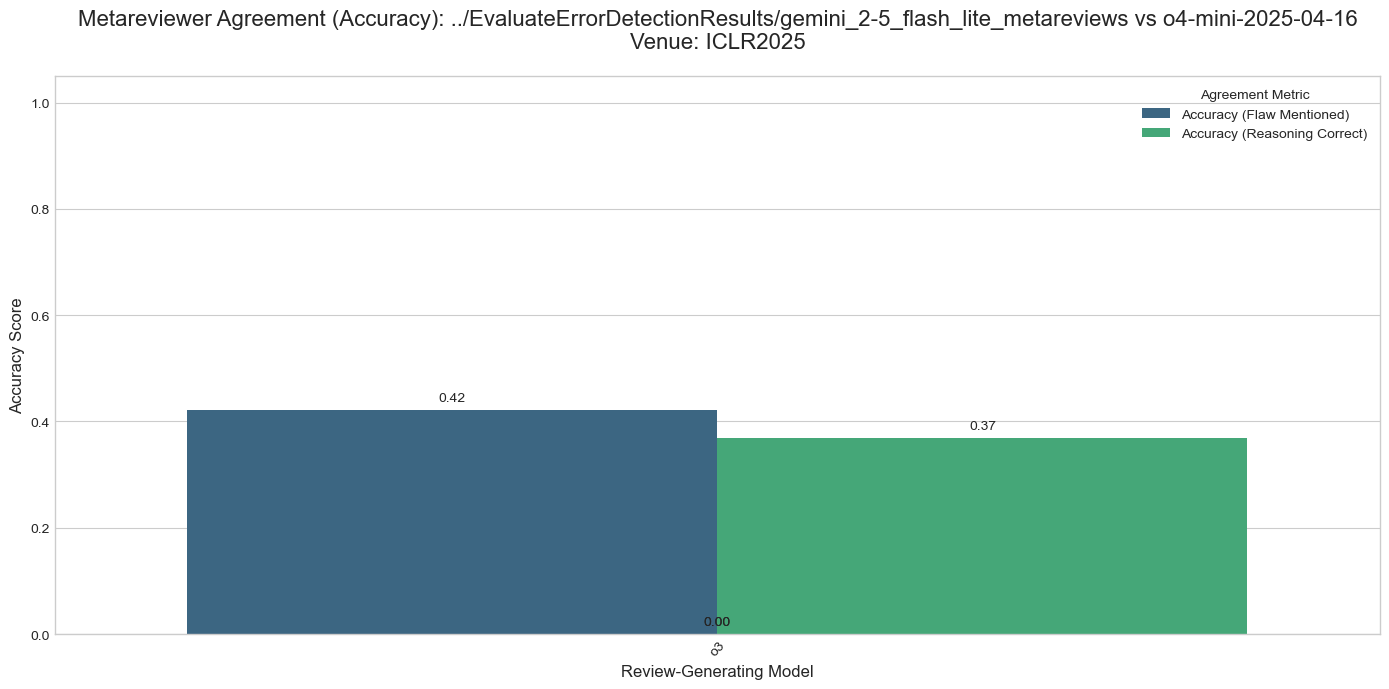

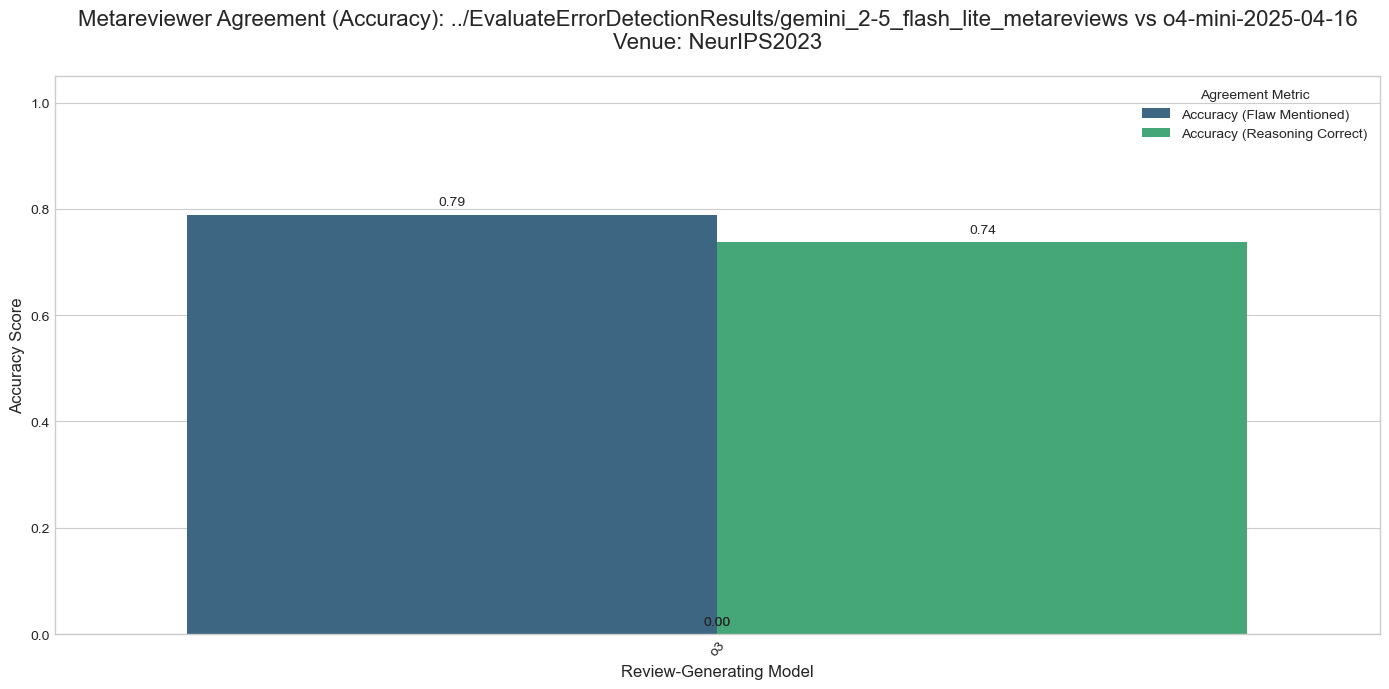

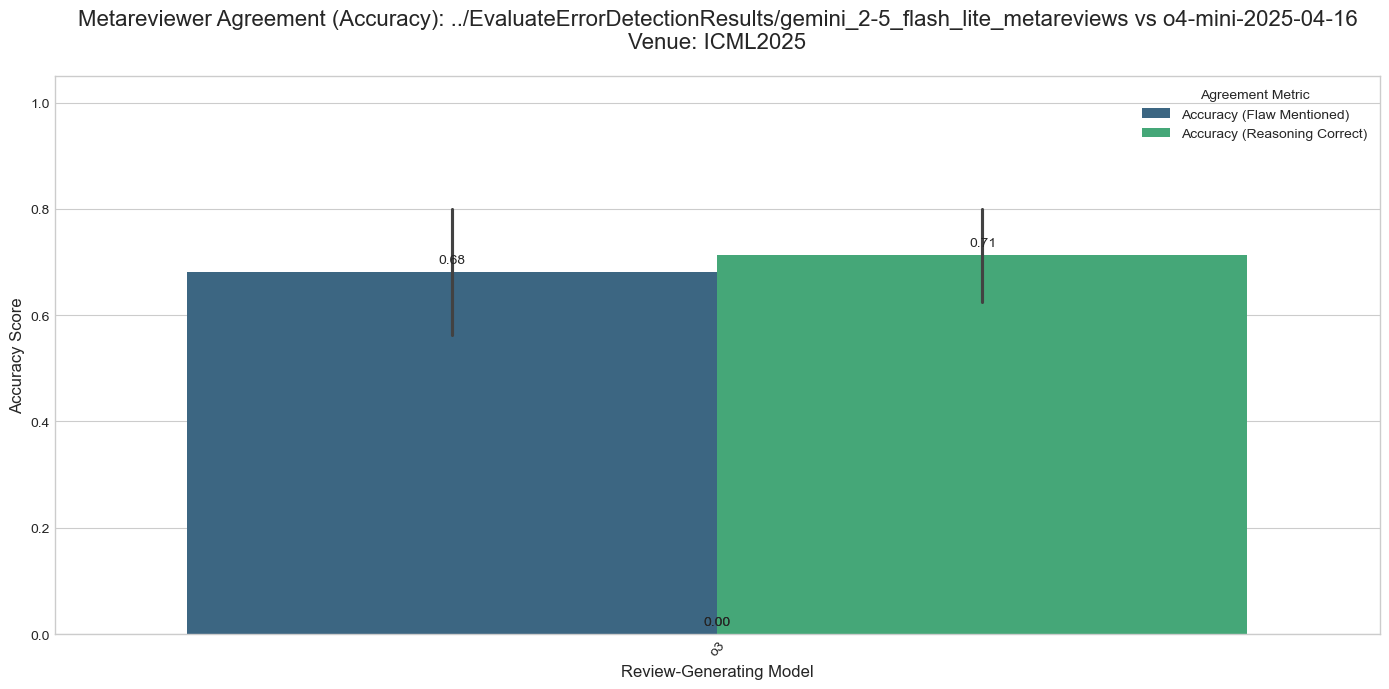

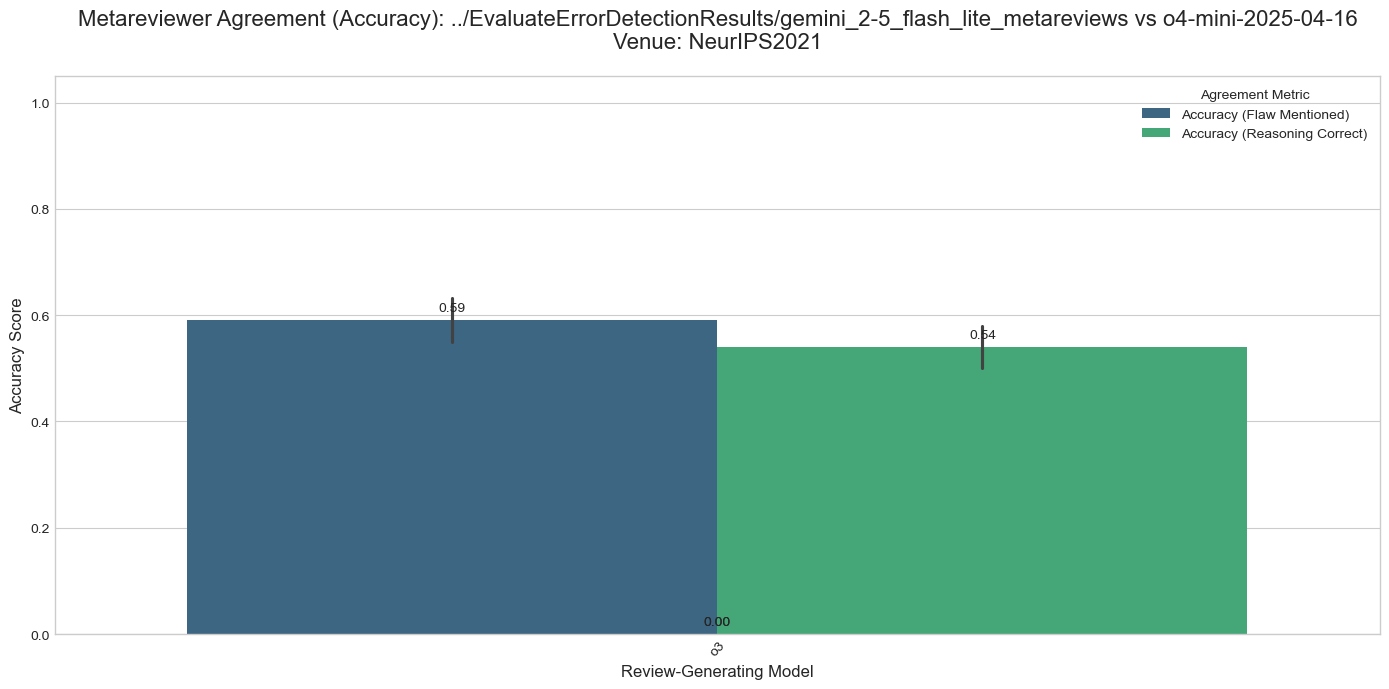

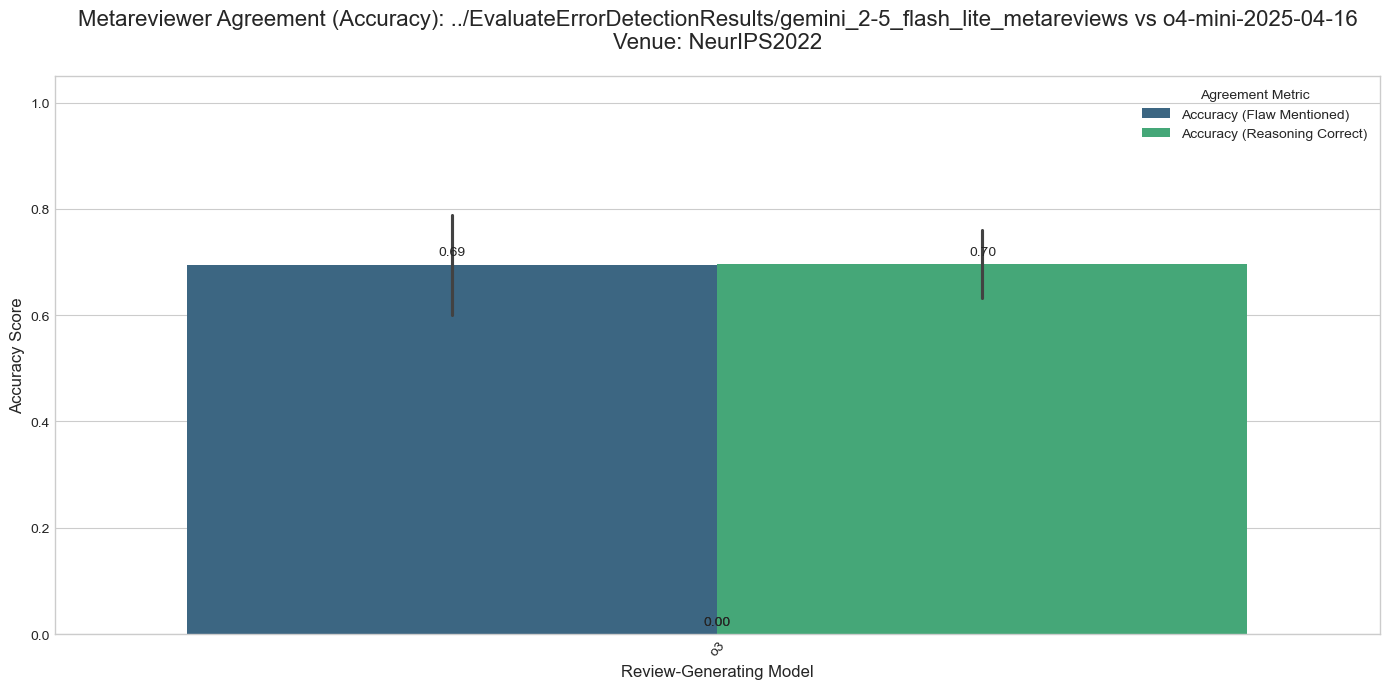

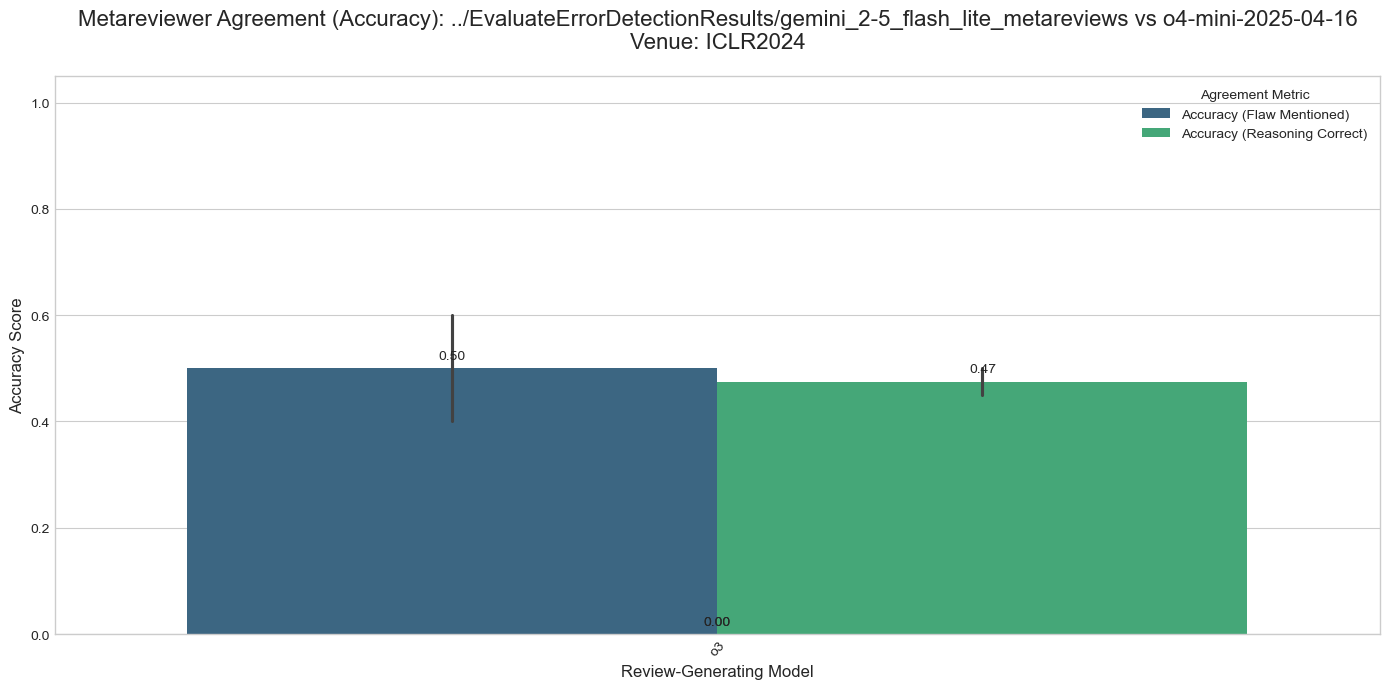

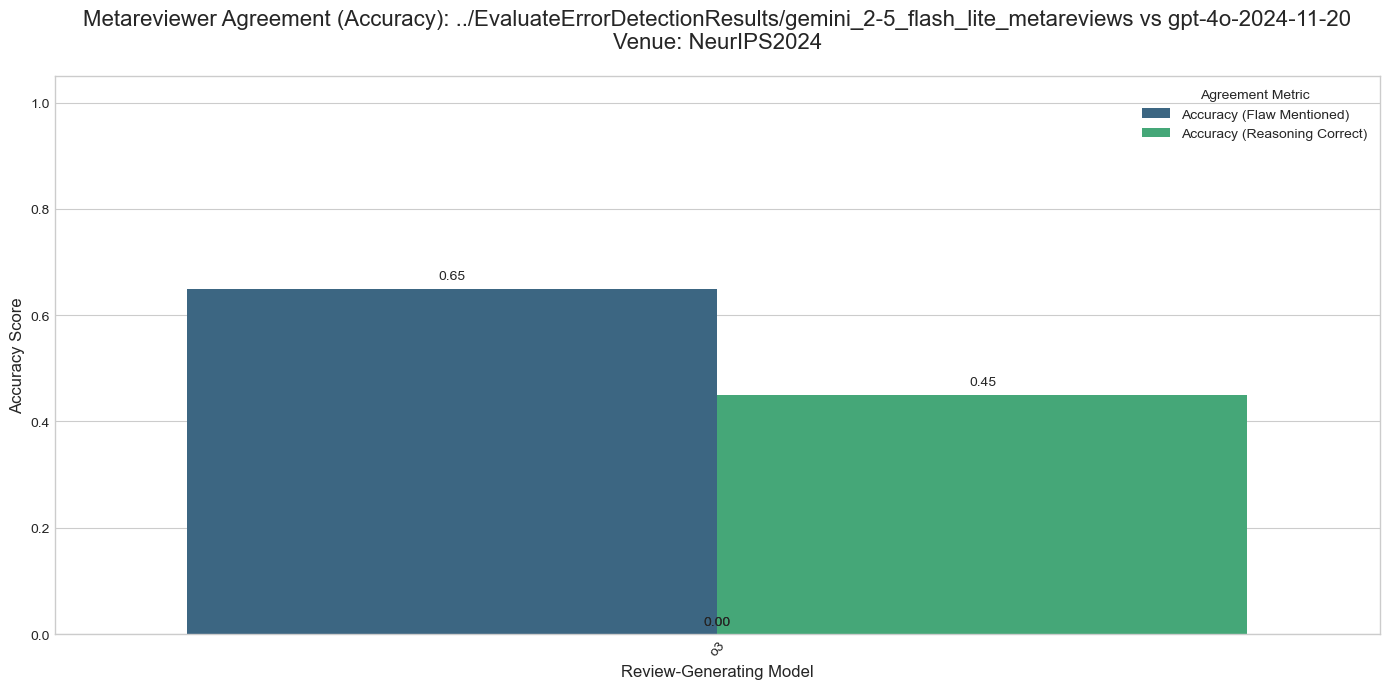

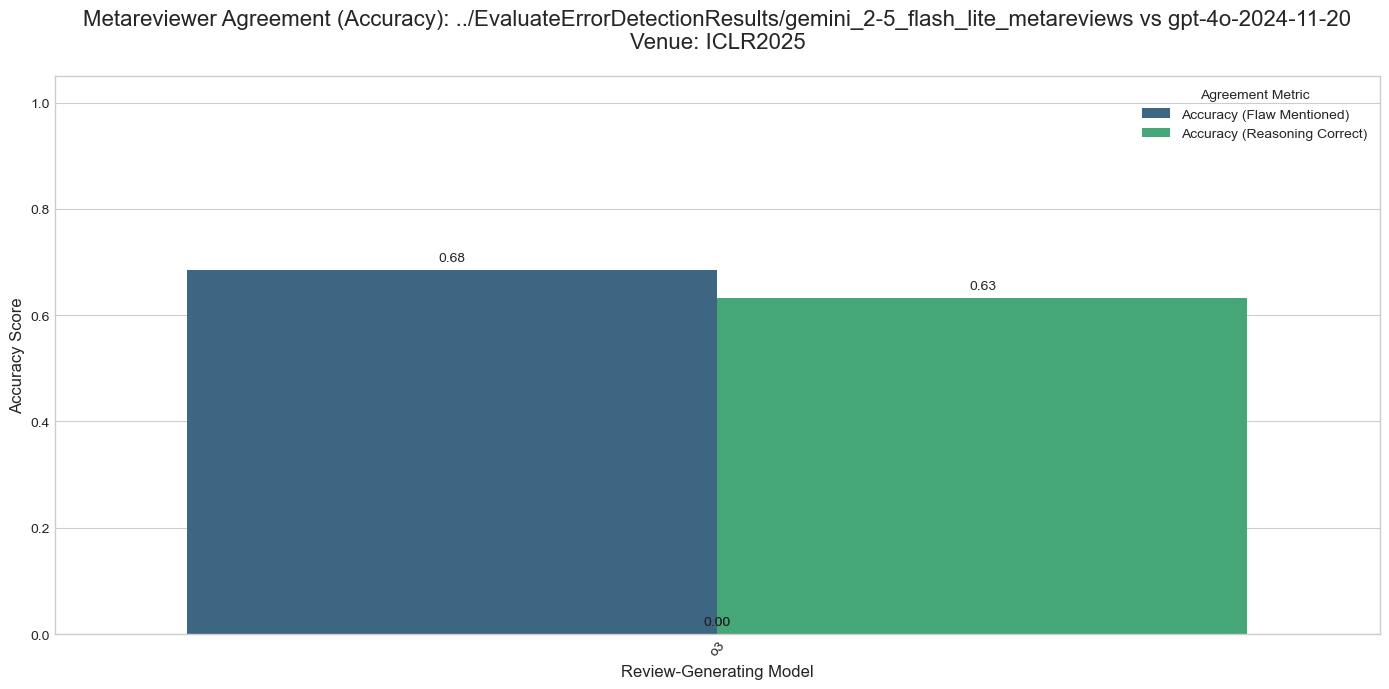

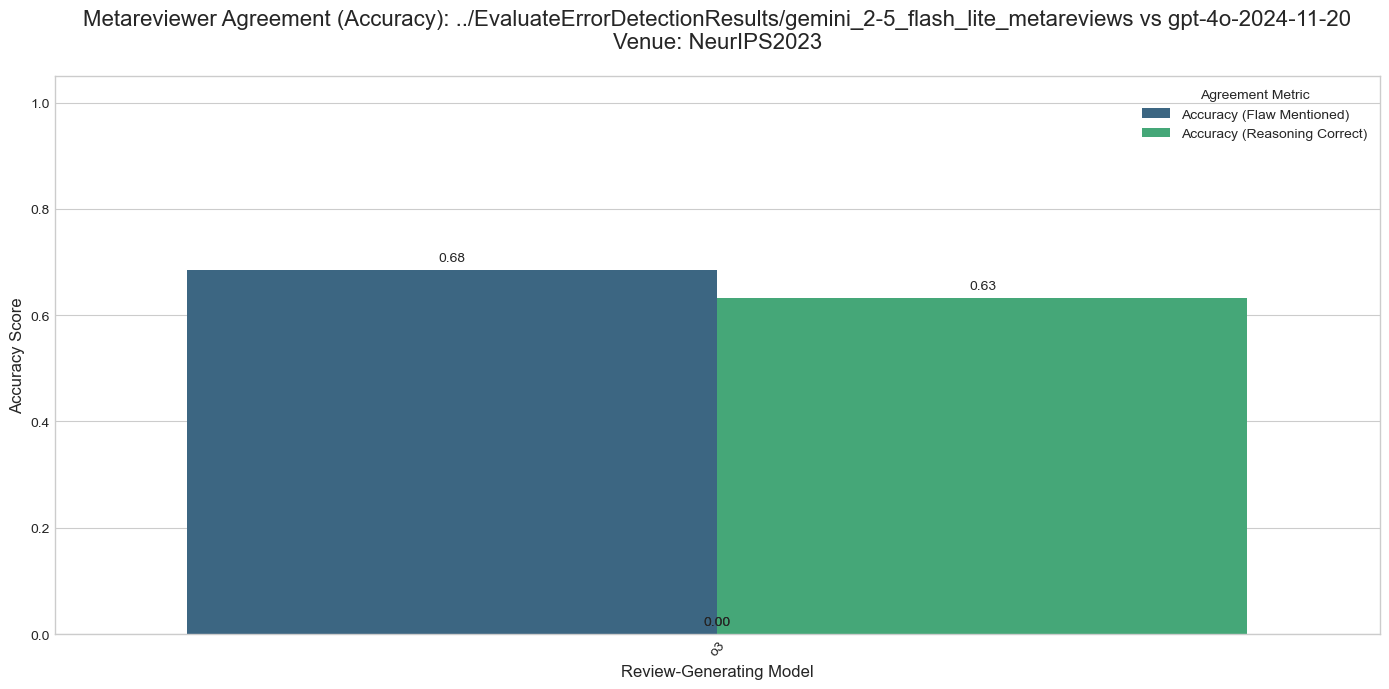

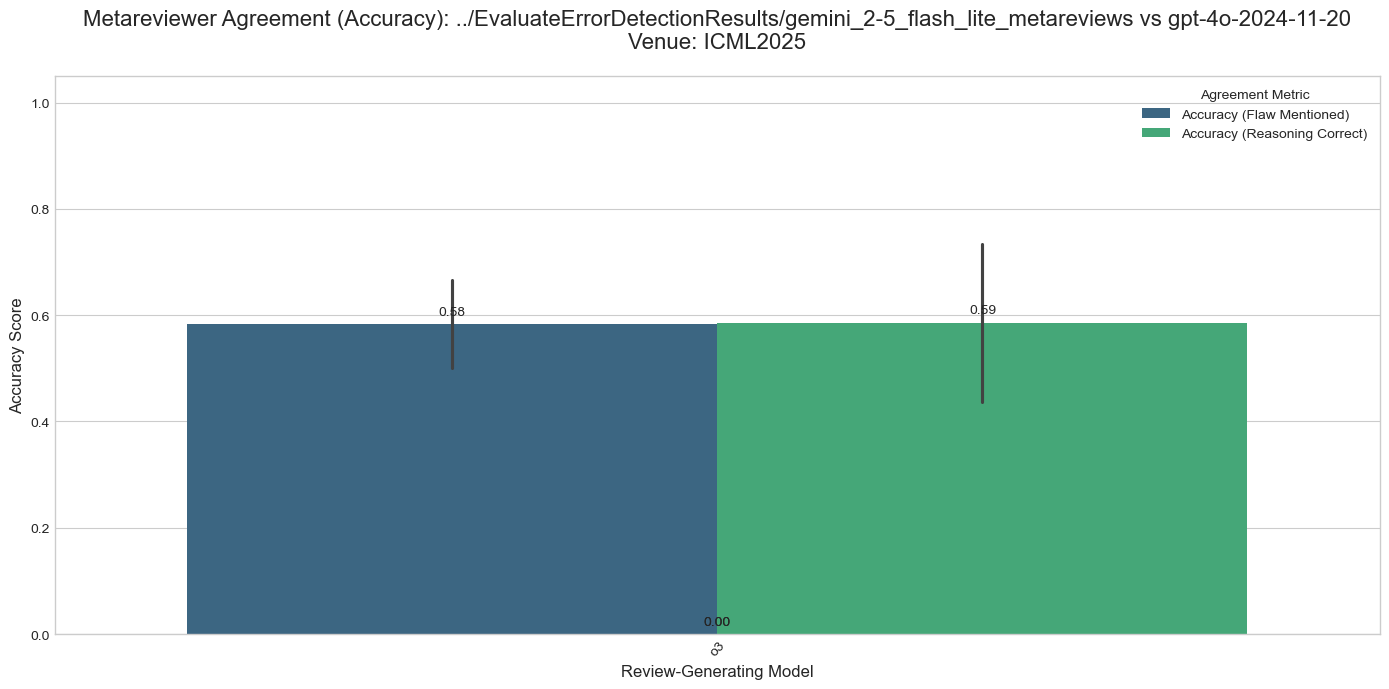

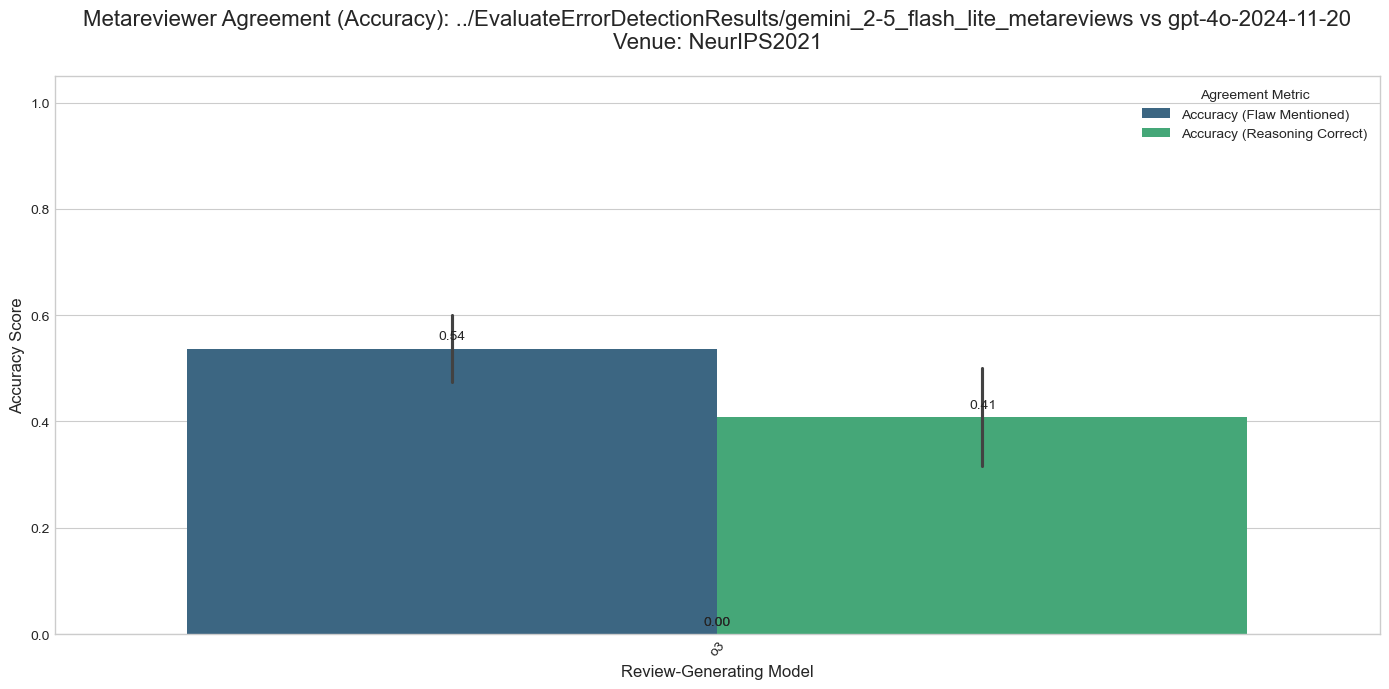

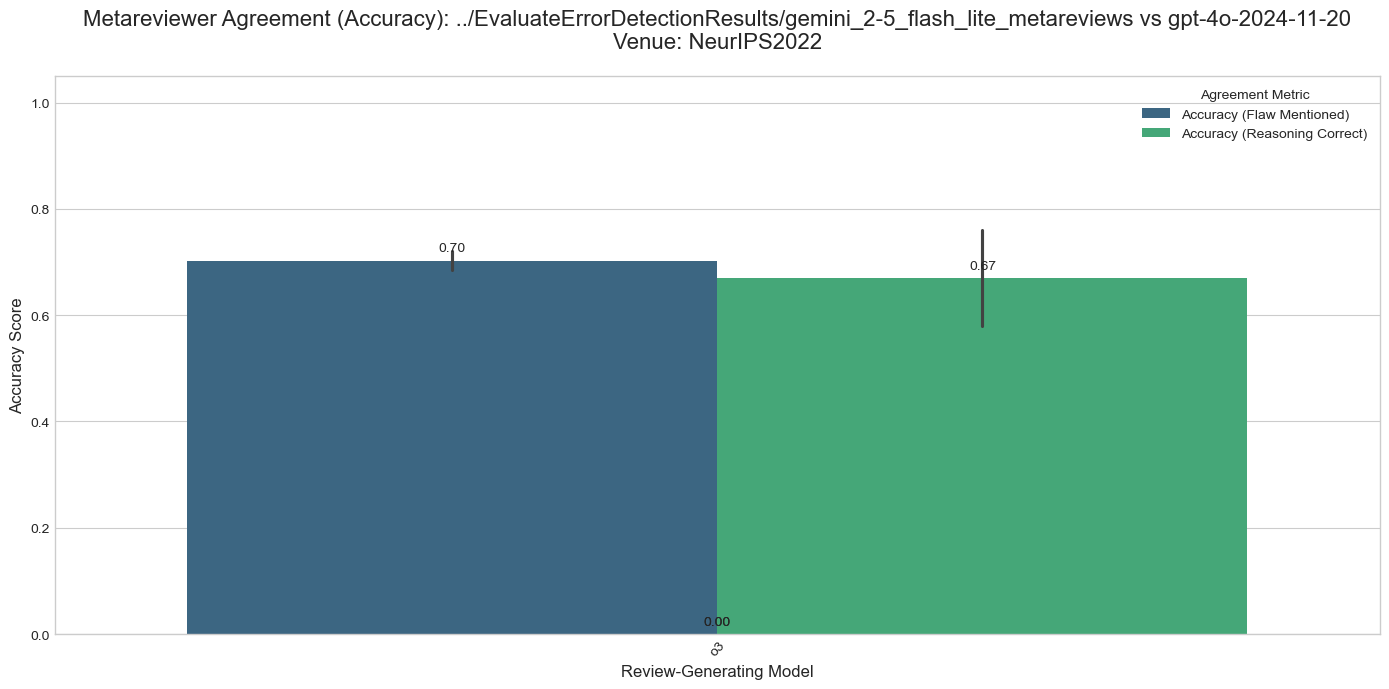

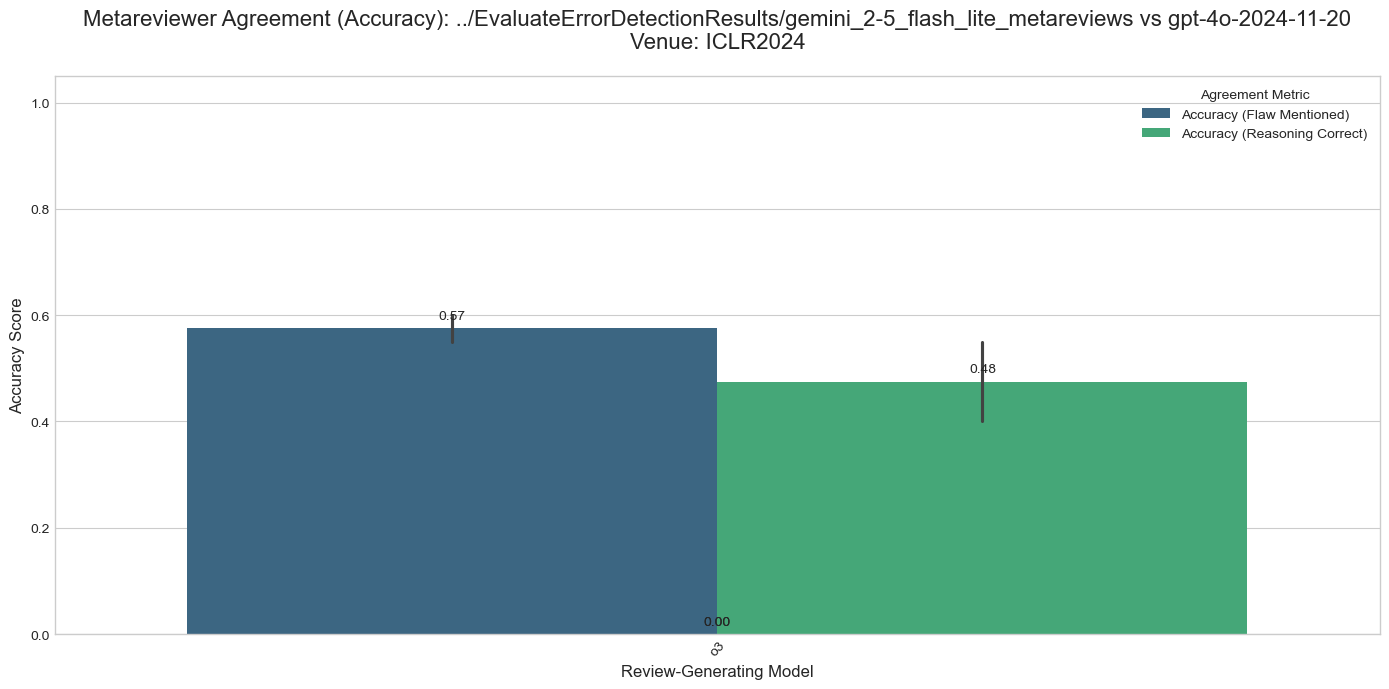

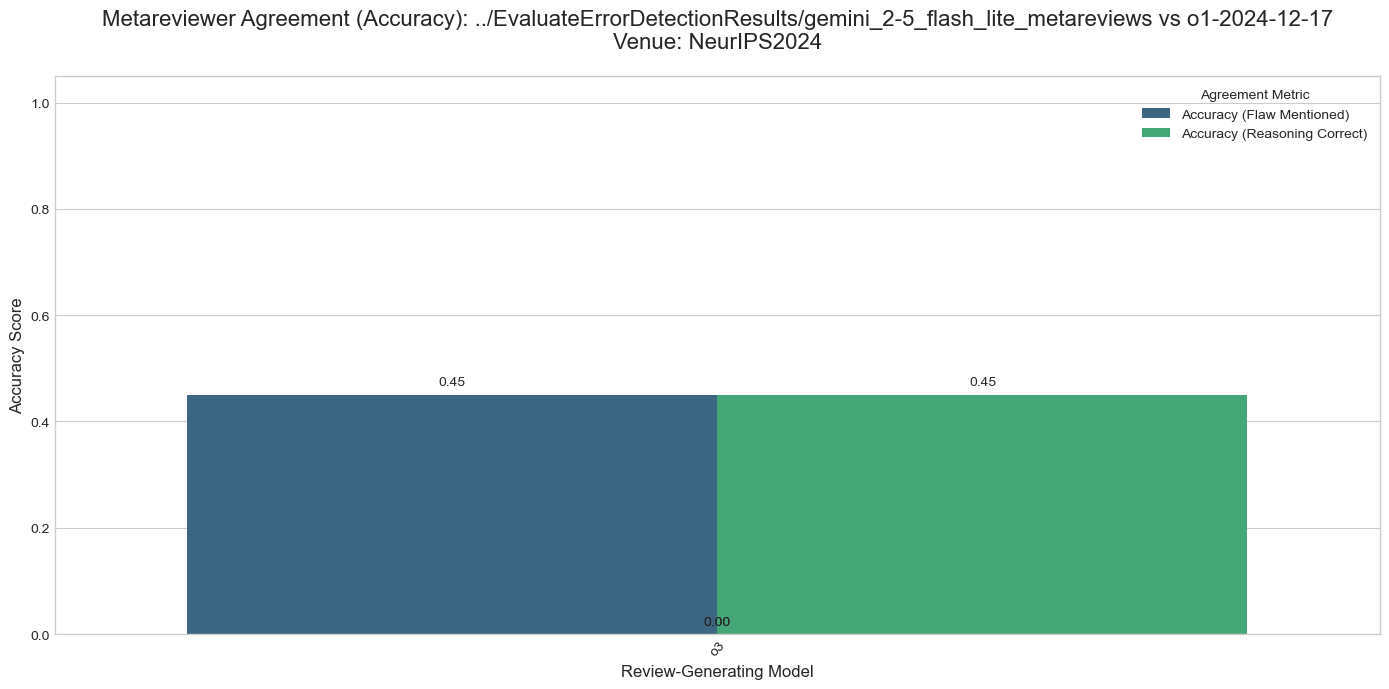

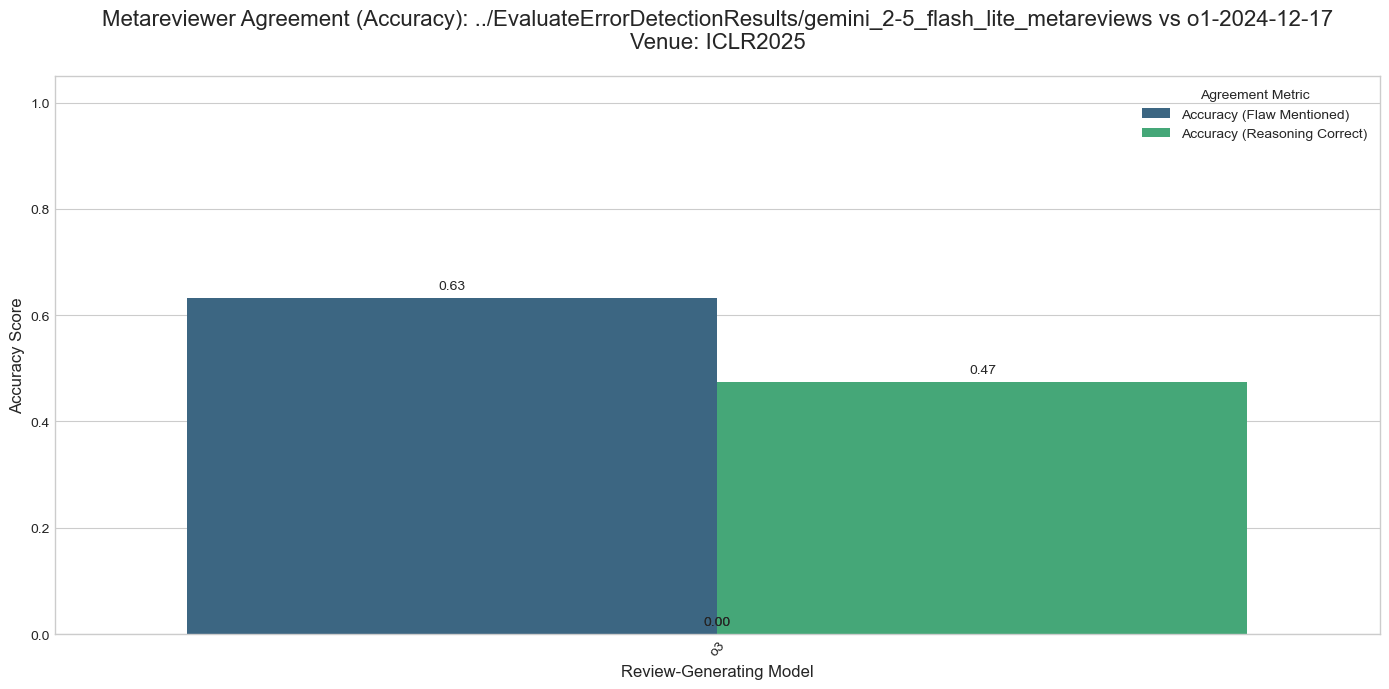

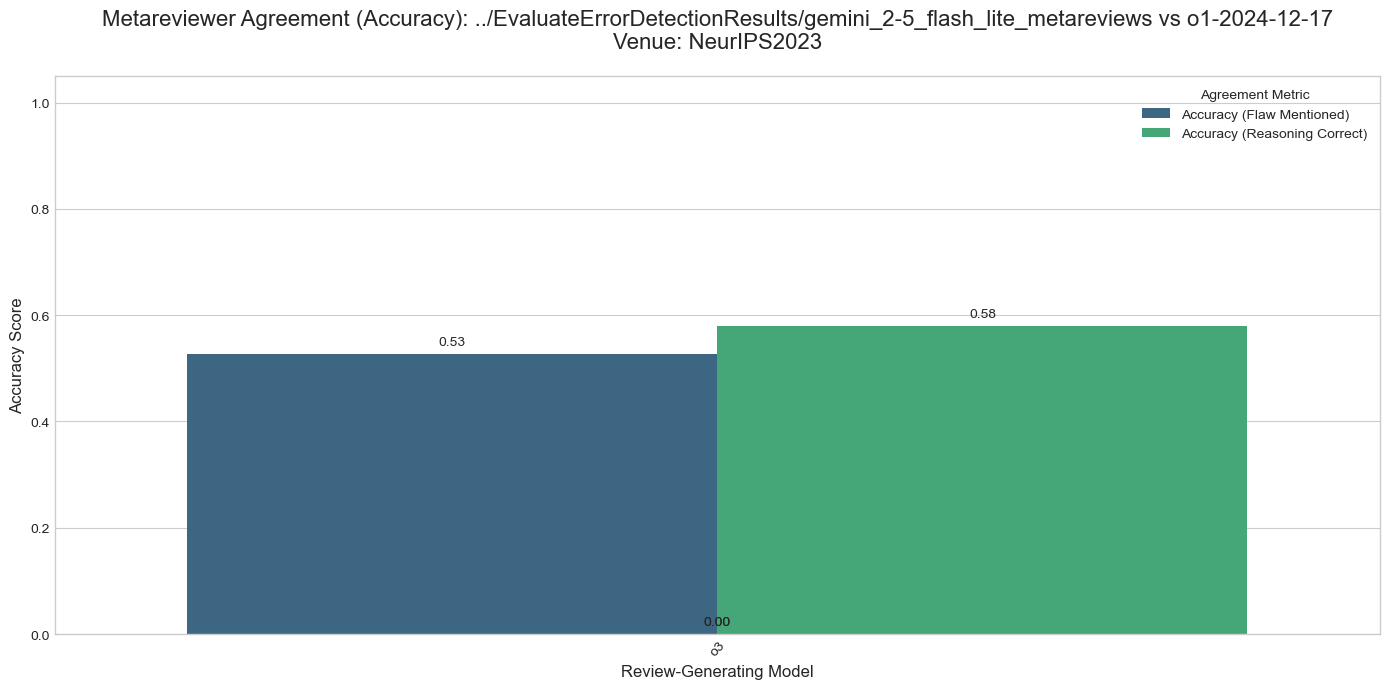

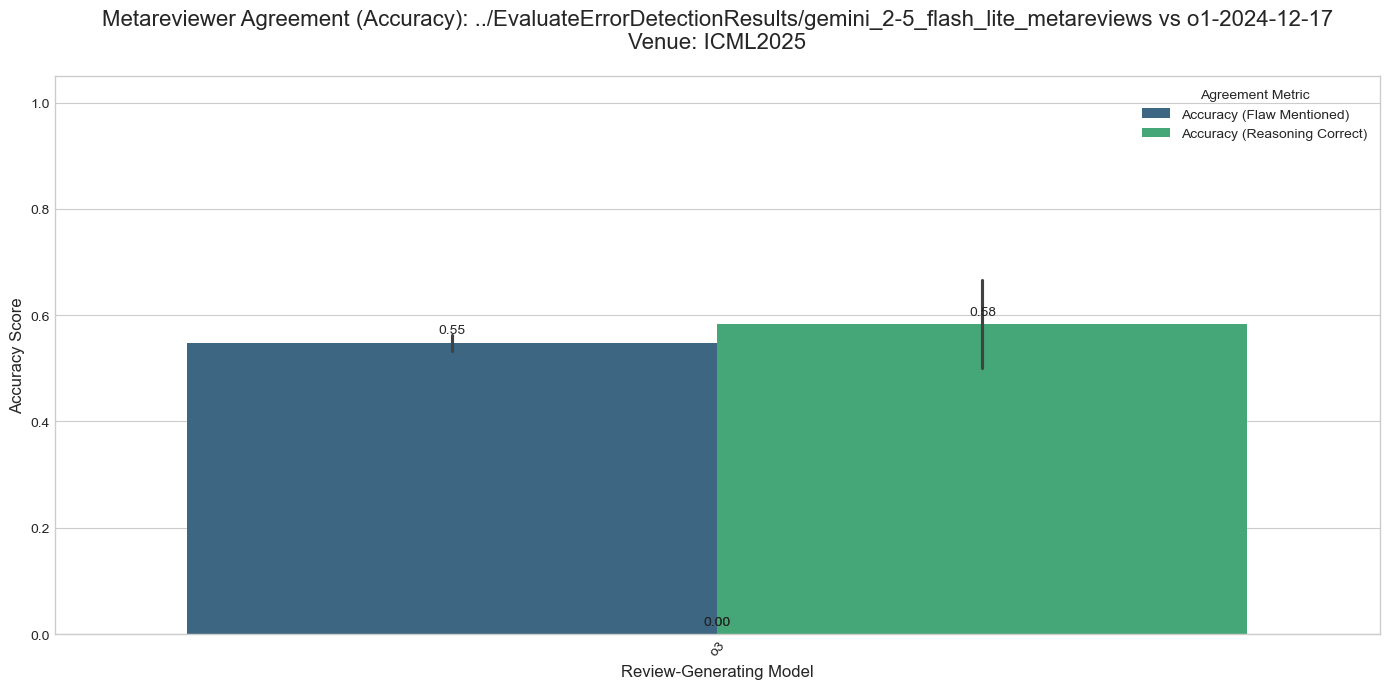

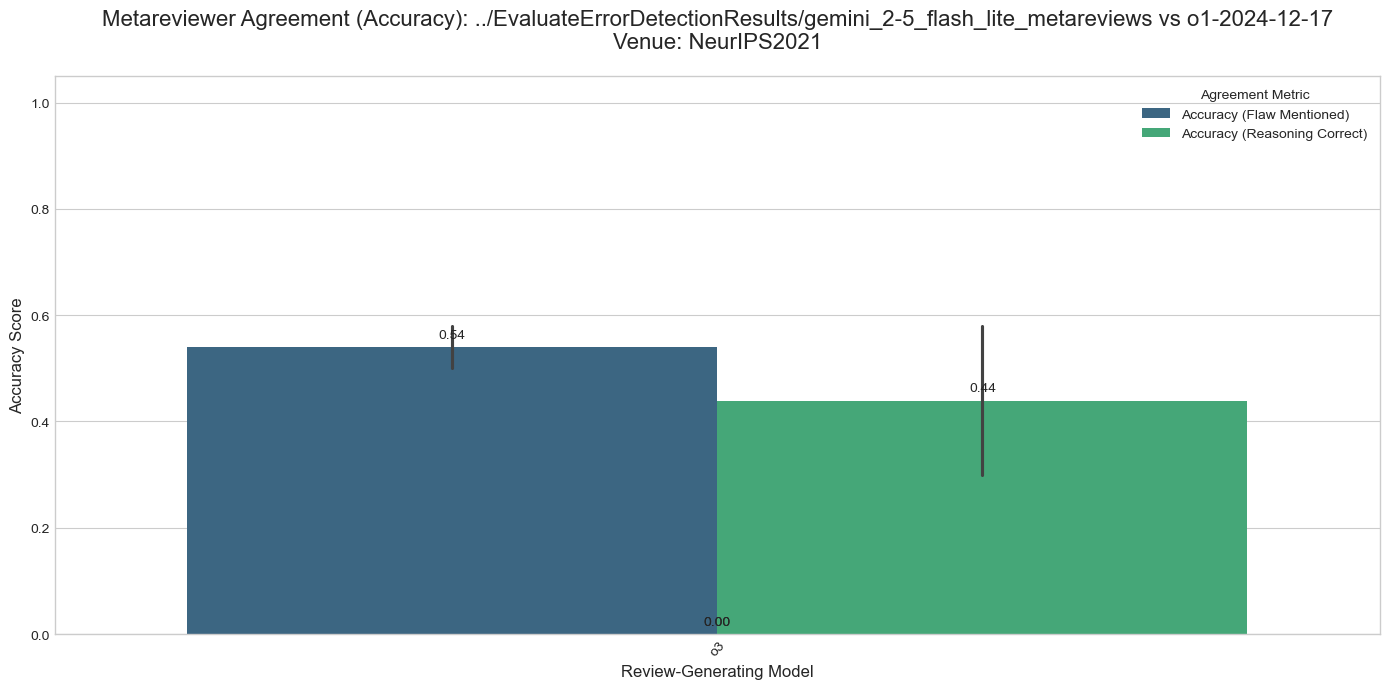

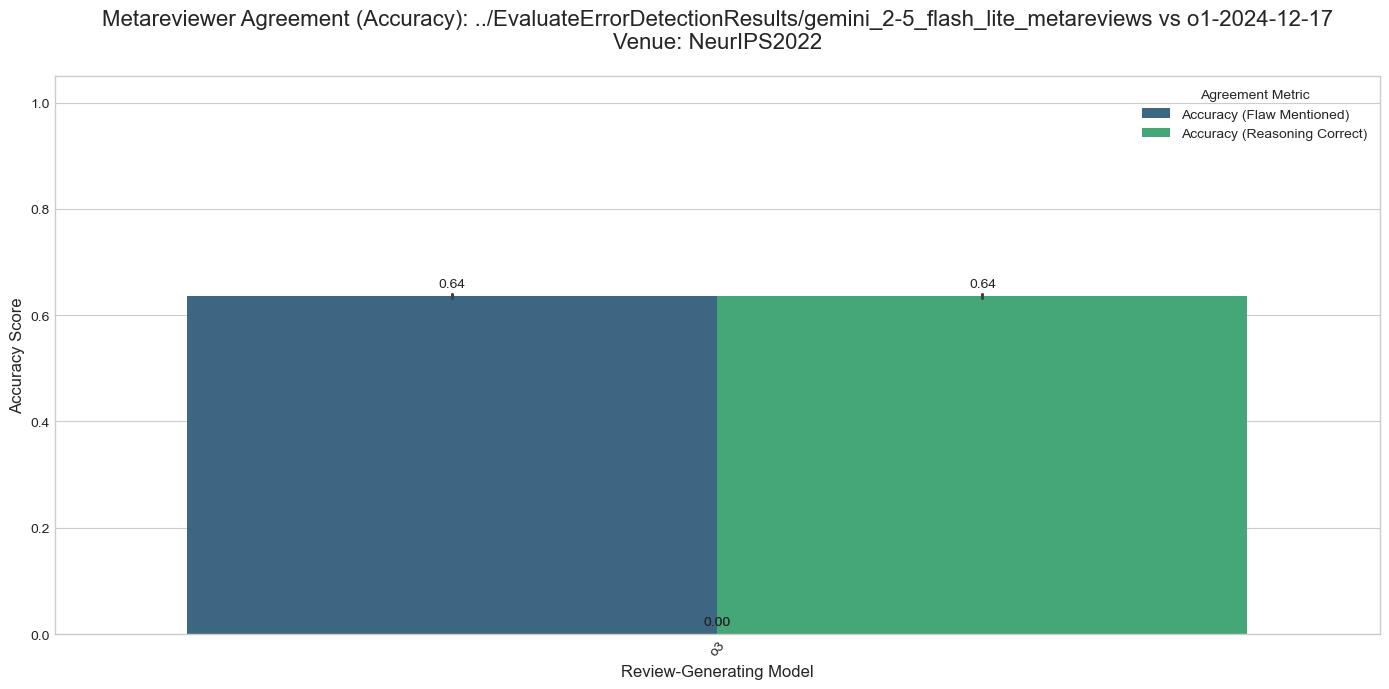

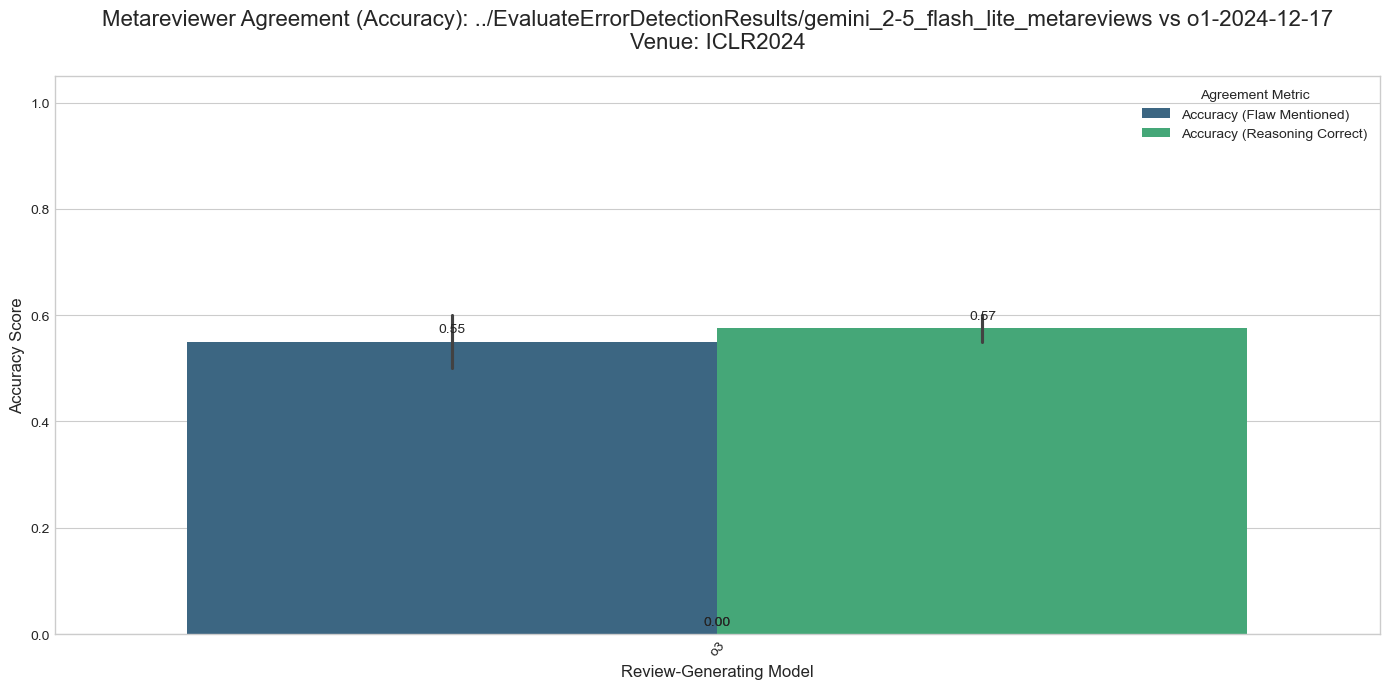

In [3]:
import os
import json
import pandas as pd
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import re

# --- Configuration ---
# Adjust these paths to match your folder names
PREDICTIONS_DIR = "../EvaluateErrorDetectionResults/gemini_2-5_flash_lite_metareviews" # Treat this as the "ground truth"
GROUND_TRUTH_DIR = "../EvaluateErrorDetectionResults/data_sampled/metareviews"      # Treat this as the "predictions"

# --- Helper Functions ---

def flatten_data(file_path):
    """
    Loads a JSON file and flattens its structure into a list of records,
    one for each flaw evaluation.
    """
    records = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        for paper_id, flaws in data.items():
            for flaw_eval in flaws:
                # Ensure the record has the necessary keys, handling potential errors
                if isinstance(flaw_eval, dict) and 'flaw_id' in flaw_eval:
                    records.append({
                        'paper_id': paper_id,
                        'flaw_id': flaw_eval.get('flaw_id'),
                        'is_flaw_mentioned': flaw_eval.get('is_flaw_mentioned'),
                        'is_reasoning_correct': flaw_eval.get('is_reasoning_correct')
                    })
    except (json.JSONDecodeError, FileNotFoundError, IOError) as e:
        print(f"Warning: Could not process file {file_path}. Error: {e}")
    return records

def calculate_metrics(df, y_true_col, y_pred_col):
    """Calculates classification metrics between two boolean columns."""
    # Drop rows where either label is missing to ensure a fair comparison
    df_clean = df.dropna(subset=[y_true_col, y_pred_col])
    
    y_true = df_clean[y_true_col]
    y_pred = df_clean[y_pred_col]
    
    if len(y_true) == 0:
        return {
            'accuracy': np.nan, 'precision': np.nan,
            'recall': np.nan, 'f1': np.nan, 'support': 0
        }

    # Use zero_division=0 to handle cases where a class is not predicted
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'support': len(y_true)
    }

# --- Main Analysis Logic ---

def analyze_metareviewer_agreement(truth_dir, predictions_dir):
    """
    Finds corresponding files, aligns data, calculates agreement metrics,
    and returns a DataFrame with the results.
    """
    all_results = []
    
    # --- Step 1: Catalog all files from both directories ---
    files_in_truth_dir = glob.glob(os.path.join(truth_dir, "**/*.json"), recursive=True)
    files_in_predictions_dir = glob.glob(os.path.join(predictions_dir, "**/*.json"), recursive=True)

    if not files_in_truth_dir:
        print(f"Error: No JSON files found in the ground truth directory: {truth_dir}")
        return pd.DataFrame()
    if not files_in_predictions_dir:
        print(f"Error: No JSON files found in the predictions directory: {predictions_dir}")
        return pd.DataFrame()

    print(f"Found {len(files_in_truth_dir)} files in {truth_dir}.")
    print(f"Found {len(files_in_predictions_dir)} files in {predictions_dir}. Starting comparison...")

    # --- Step 2: Parse and map files from the predictions directory ---
    predictions_map = {}
    for path in files_in_predictions_dir:
        filename = os.path.basename(path)
        try:
            parts = filename.replace('_evaluated.json', '').split('_')
            review_model = parts[0]
            status = parts[-1]
            venue = "_".join(parts[1:-1])
            predictions_map[(review_model, venue, status)] = path
        except IndexError:
            print(f"Warning (predictions): Could not parse filename, skipping: {filename}")

    # --- Step 3: Parse truth files and find matches in the predictions map ---
    print(f"\nFound {len(predictions_map)} parsable prediction files.")
    
    for truth_file_path in files_in_truth_dir:
        try:
            path_parts = Path(truth_file_path).parts
            filename = os.path.basename(truth_file_path)
            
            relative_path = os.path.relpath(truth_file_path, truth_dir)
            ground_truth_metareviewer = Path(relative_path).parts[0]

            review_model, venue, status = None, None, None
            
            if "_evaluated.json" in filename:
                parts = filename.replace('_evaluated.json', '').split('_')
                review_model = parts[0]
                status = parts[-1]
                venue = "_".join(parts[1:-1])
            elif "metareviews_by_" in filename:
                review_model = filename.replace('metareviews_by_', '').replace('.json', '')
                status = path_parts[-2]
                venue = path_parts[-3]
            else:
                continue

            prediction_key = (review_model, venue, status)
            if prediction_key in predictions_map:
                prediction_file_path = predictions_map[prediction_key]
                
                print(f"\nMatching pair found for Review Model '{review_model}' | Venue '{venue}' | Status '{status}':")
                print(f"  - Truth File (from {ground_truth_metareviewer}): {os.path.relpath(truth_file_path, truth_dir)}")
                print(f"  - Prediction File: {os.path.basename(prediction_file_path)}")

                df_truth = pd.DataFrame(flatten_data(truth_file_path))
                df_pred = pd.DataFrame(flatten_data(prediction_file_path))

                if df_truth.empty or df_pred.empty:
                    print("  - One or both files are empty or failed to load. Skipping.")
                    continue

                merged_df = pd.merge(df_truth, df_pred, on=['paper_id', 'flaw_id'], suffixes=('_truth', '_pred'))
            

                if merged_df.empty:
                    print("  - No common paper/flaw IDs found between the two files. Skipping.")
                    continue

                mention_metrics = calculate_metrics(merged_df, 'is_flaw_mentioned_truth', 'is_flaw_mentioned_pred')
                reasoning_metrics = calculate_metrics(merged_df, 'is_reasoning_correct_truth', 'is_reasoning_correct_pred')

                all_results.append({
                    'review_model': review_model,
                    'ground_truth_metareviewer': ground_truth_metareviewer,
                    'venue': venue,
                    'status': status,
                    'support': mention_metrics['support'],
                    'f1_mention': mention_metrics['f1'],
                    'acc_mention': mention_metrics['accuracy'],
                    'f1_reasoning': reasoning_metrics['f1'],
                    'acc_reasoning': reasoning_metrics['accuracy'],
                })
        except (IndexError, ValueError) as e:
            print(f"Warning (truth): Error parsing path, skipping: {truth_file_path}. Error: {e}")

    return pd.DataFrame(all_results)

def plot_metrics(df, metric_cols, title_suffix):
    """A generic function to plot specified metrics (F1 or Accuracy)."""
    if df.empty:
        print(f"Cannot plot {title_suffix} because no data was generated.")
        return
        
    df['venue_short'] = df['venue'].str.replace('_latest_flawed_papers_v1', '')
    
    unique_comparisons = df[['ground_truth_metareviewer', 'venue_short']].drop_duplicates()

    for _, row in unique_comparisons.iterrows():
        gt_meta = row['ground_truth_metareviewer']
        venue = row['venue_short']
        
        plot_df = df[(df['ground_truth_metareviewer'] == gt_meta) & (df['venue_short'] == venue)]
        
        if plot_df.empty: continue

        plot_data_melted = plot_df.melt(
            id_vars='review_model', 
            value_vars=metric_cols,
            var_name='Metric', 
            value_name='Score'
        )
        plot_data_melted['Metric'] = plot_data_melted['Metric'].map({
            metric_cols[0]: f'{title_suffix} (Flaw Mentioned)',
            metric_cols[1]: f'{title_suffix} (Reasoning Correct)'
        })

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(14, 7))
        
        ax = sns.barplot(
            data=plot_data_melted,
            x='review_model',
            y='Score',
            hue='Metric',
            palette='viridis'
        )
        
        ax.set_title(f'Metareviewer Agreement ({title_suffix}): {PREDICTIONS_DIR} vs {gt_meta}\nVenue: {venue}', fontsize=16, pad=20)
        ax.set_xlabel('Review-Generating Model', fontsize=12)
        ax.set_ylabel(f'{title_suffix} Score', fontsize=12)
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis='x', rotation=45)
        
        for p in ax.patches:
            ax.annotate(
                format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10
            )
            
        plt.legend(title='Agreement Metric')
        plt.tight_layout()
        plt.show()


# --- Run the Analysis ---
# In a notebook, you might need to use display() to render the DataFrame nicely
from IPython.display import display

results_df = analyze_metareviewer_agreement(GROUND_TRUTH_DIR, PREDICTIONS_DIR)

if not results_df.empty:
    print("\n--- Agreement Metrics ---")
    display(results_df.sort_values(by=['ground_truth_metareviewer', 'venue', 'review_model']).reset_index(drop=True))
    
    # Plot the results for both F1 Score and Accuracy
    print("\n--- F1 Score Visualizations ---")
    plot_metrics(results_df, ['f1_mention', 'f1_reasoning'], 'F1')
    
    print("\n--- Accuracy Score Visualizations ---")
    plot_metrics(results_df, ['acc_mention', 'acc_reasoning'], 'Accuracy')
else:
    print("\nNo matching files found for comparison. Please check directory paths and file structures.")

